# Driver Aggression Neural Network (DANN)

Driver Aggression Neural Network is assigning an aggression value to a sorted set of sensory data. Driving is simulated in BeamNG v0.27 using their BeamNGpy open-source library.

In [2]:
import pandas as pd
import torch
import glob
import uuid

parquet_file_path = '../data/imu/imu_data*.parquet'
file_list = glob.glob(parquet_file_path)

# Initialize an empty list to hold the dataframes
df_list = []
# Loop through the file list and read each file into a dataframe
for file in file_list:
    df = pd.read_parquet(file)
    # Assign UUID to imuId
    # create a dictionary that maps each unique imuId to a random UUID
    uuid_dict = {imuId: str(uuid.uuid4()) for imuId in df['imuId'].unique()}
    # replace imuId values using the dictionary
    df['imuId'] = df['imuId'].map(uuid_dict)
    df_list.append(df)

# Concatenate all the dataframes into a single dataframe
data = pd.concat(df_list, ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modify training data

- Group together data recorded from the same sensor
- Take around 100-1000 recorded data without the aggression values
- Make aggression values the label of the dataset
- Create a lot of training data by chunking the sorted (by timestamp) records.

           time     dirXX     dirXY     dirXZ     dirYX     dirYY     dirYZ     dirZX     dirZY     dirZZ    accRawX    accRawY   accRawZ  accSmoothX  accSmoothY  accSmoothZ
450591  0.00000 -0.968906 -0.242807 -0.047608 -0.054473  0.021634  0.998281 -0.241360  0.969833 -0.034188  -5.977298   7.713431 -1.231694   -5.600171    5.639621   -0.683527
450592  0.00325  0.810294  0.584992  0.034756 -0.005741 -0.051382  0.998663  0.585996 -0.809410 -0.038276   3.011816   2.807095  3.367281    2.756299    3.208518    3.223858
450593  0.00425 -0.728907 -0.683576 -0.037658 -0.016761 -0.037171  0.999168 -0.684407  0.728932  0.015637  -3.730192  -7.324857  1.186967   -3.085579   -5.893360    1.137513
450594  0.00925 -0.820979 -0.570930 -0.005694 -0.008440  0.002163  0.999962 -0.570896  0.820996 -0.006595   0.007460   0.061873 -0.072362    0.024803    0.058614   -0.054538
450595  0.01250  0.009124 -0.989810  0.142105 -0.011105  0.142002  0.989804 -0.999897 -0.010609 -0.009696   1.484269   0.880598  0

C:\Users\illya\AppData\Local\Temp\ipykernel_15816\1572142400.py:123: FutureWarning: column_space is deprecated and will be removed in a future version. Use df.to_string(col_space=...) instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_15816\1572142400.py:123: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  pd.reset_option("all")
C:\Users\illya\AppData\Local\Temp\ipykernel_15816\1572142400.py:123: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  pd.reset_option("all")


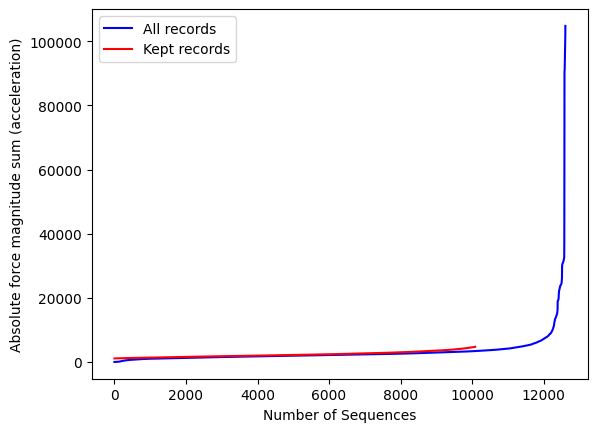

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Assuming 'data' is your Scheme
# data = pd.DataFrame(columns=[
#     'imuId',
#     'vehicleAggression',
#     'time',
#     'pos',
#     'dirX',
#     'dirY',
#     'dirZ',
#     'angVel',
#     'angAccel',
#     'mass',
#     'accRaw',
#     'accSmooth'
# ])

# Function to split the data into chunks
def split_into_chunks(data, chunk_size):
    return [data[i:i+chunk_size] for i in range(0, len(data), chunk_size)]

def remove_volatile_records(training_data, trim_start=0.2, trim_end=0.0):
    # Calculate the sum of force magnitude for each sequence
    chosen_index = random.randint(0, len(training_data) - 1)
    for index, item in enumerate(training_data):
        data = item['data']
        data['forceMagnitude'] = np.linalg.norm(data[['accSmoothX', 'accSmoothY', 'accSmoothZ']], axis=1)
        # Plot the force magnitudes for a random sequence
        # if index == chosen_index:
        #     plt.plot(data['forceMagnitude'])
        #     plt.show()
        item['forceSum'] = data['forceMagnitude'].sum()
        data.drop('forceMagnitude', axis=1, inplace=True)

    # Sort the sequences by the sum of force magnitude
    training_data.sort(key=lambda x: x['forceSum'], reverse=False)

    # Keep only the most volatile top% of the sequences
    trimmed_start = int(len(training_data) * trim_start)
    trimmed_end = int(len(training_data) * (1 - trim_end))
    
    # Plot the force magnitude sum for each sequence
    plt.plot([item['forceSum'] for item in training_data], label='All records', color='blue')
    plt.ylabel('Absolute force magnitude sum (acceleration)')
    plt.xlabel('Number of Sequences')
    
    # Plot the force magnitude sum for each sequence after cutoff with label
    plt.plot([item['forceSum'] for item in training_data[trimmed_start:trimmed_end]], label='Kept records', color='red')
    plt.legend()
    
    return pd.DataFrame(training_data[trimmed_start:trimmed_end])

# Group the data by 'imuId' and sort within each group by 'time'
grouped_data = data.groupby('imuId').apply(lambda x: x.sort_values('time')).reset_index(drop=True)

# Set the desired chunk size (number of records per chunk)
chunk_size = 400

# Split the data into chunks and assign the 'vehicleAggression' value as the label
training_data = []
for imu_id, group in grouped_data.groupby('imuId'):
    group.dropna()
    chunks = split_into_chunks(group, chunk_size)
    for chunk in chunks:
        if len(chunk) >= chunk_size:
            label = chunk['vehicleAggression'].iloc[0]
            first_timestamp = chunk['time'].iloc[0]
            adjusted_time = chunk['time'] - first_timestamp
            
            # Separate list columns into individual columns
            # pos_df = pd.DataFrame(chunk['pos'].tolist(), columns=['posX', 'posY', 'posZ'], index=chunk.index)
            dir_x_df = pd.DataFrame(chunk['dirX'].tolist(), columns=['dirXX', 'dirXY', 'dirXZ'], index=chunk.index)
            dir_y_df = pd.DataFrame(chunk['dirY'].tolist(), columns=['dirYX', 'dirYY', 'dirYZ'], index=chunk.index)
            dir_z_df = pd.DataFrame(chunk['dirZ'].tolist(), columns=['dirZX', 'dirZY', 'dirZZ'], index=chunk.index)
            acc_raw_df = pd.DataFrame(chunk['accRaw'].tolist(), columns=['accRawX', 'accRawY', 'accRawZ'], index=chunk.index)
            acc_smooth_df = pd.DataFrame(chunk['accSmooth'].tolist(), columns=['accSmoothX', 'accSmoothY', 'accSmoothZ'], index=chunk.index)
            ang_vel_df = pd.DataFrame(chunk['angVel'].tolist(), columns=['angVelX', 'angVelY', 'angVelZ'], index=chunk.index)
            ang_accel_df = pd.DataFrame(chunk['angAccel'].tolist(), columns=['angAccelX', 'angAccelY', 'angAccelZ'], index=chunk.index)
            
            expanded_chunk = pd.concat(
                [
                    chunk,
                    # pos_df,
                    dir_x_df,
                    dir_y_df,
                    dir_z_df,
                    acc_raw_df,
                    acc_smooth_df,
                    # ang_vel_df,
                    # ang_accel_df
                ],
                axis=1
            )
            
            updated_chunk = (
                expanded_chunk.assign(time=adjusted_time)
                .drop(['imuId', 'mass', 'vehicleAggression', 'pos', 'dirX', 'dirY', 'dirZ', 'angVel', 'angAccel', 'accRaw', 'accSmooth'], axis=1)
            )
            
            training_data.append({'data': updated_chunk, 'label': label})

# Remove records with identical rows
training_data = [item for item in training_data if not item['data'].duplicated().any()]

# Keep the most volatile records (based on force magnitude)
trim_low_acceleration_records = 0.1 # default 0.2
trim_volatile_records = 0.1 # default 0.05

# Remove the most volatile records from the training data
training_data_df = remove_volatile_records(training_data, trim_start=trim_low_acceleration_records, trim_end=trim_volatile_records)

# Example of a single training set
# Set display options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", 100)  # Set the maximum column width to 100 characters
pd.set_option("display.expand_frame_repr", False)
print(training_data_df.loc[0, 'data'])
pd.reset_option("all")


## Translating the training data to learn

In [4]:
from sklearn.model_selection import train_test_split

# Get the data and labels from the training_data_df
X = np.stack(training_data_df['data'].apply(lambda x: x.to_numpy()).to_numpy())
y = training_data_df['label'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (8070, 400, 16)
X_test shape: (2018, 400, 16)
y_train shape: (8070,)
y_test shape: (2018,)


## Learn with PyTorch

- Create a TensorDataset
- Create a DataLoader, which shuffles the data
- Create a simple neural net (torch.nn.Sequential) which uses CUDA while training
- Train the neural net with the data provided
- Evaluate the net with the test data

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

X_train_2d = X_train.reshape(X_train.shape[0], -1)
X_test_2d = X_test.reshape(X_test.shape[0], -1)
X_train_rnn = X_train.reshape(-1, X_train.shape[1], X_train.shape[2])
X_test_rnn = X_test.reshape(-1, X_test.shape[1], X_test.shape[2])
print("X_train_2d shape:", X_train_2d.shape)
print("X_test_2d shape:", X_test_2d.shape)
print("X_train_rnn shape:", X_train_rnn.shape)
print("X_test_rnn shape:", X_test_rnn.shape)

# Create tensors from the padded data
X_train_tensor = torch.tensor(X_train, dtype=torch.float).to(device)
X_train_tensor_2d = torch.tensor(X_train_2d, dtype=torch.float).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float).to(device)
X_test_tensor_2d = torch.tensor(X_test_2d, dtype=torch.float).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float).to(device)

# Create a DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataset_2d = TensorDataset(X_train_tensor_2d, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataset_2d = TensorDataset(X_test_tensor_2d, y_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)

rnn_batch_size = 32 # Use for RNN
X_train_tensor_rnn = torch.tensor(X_train_rnn).to(device)
X_test_tensor_rnn = torch.tensor(X_test_rnn).to(device)
rnn_train_dataset = TensorDataset(X_train_tensor_rnn, y_train_tensor)
rnn_test_dataset = TensorDataset(X_test_tensor_rnn, y_test_tensor)
rnn_train_loader = DataLoader(rnn_train_dataset, batch_size=rnn_batch_size, shuffle=True)
rnn_test_loader = DataLoader(rnn_test_dataset, batch_size=rnn_batch_size)

X_train_2d shape: (8070, 6400)
X_test_2d shape: (2018, 6400)
X_train_rnn shape: (8070, 400, 16)
X_test_rnn shape: (2018, 400, 16)


In [6]:
def plot_evaluation(actuals: list[float], predictions: list[float]):
    plot_evaluations(actuals, {'Predictions': predictions})
    
def plot_evaluations(actuals: list[float], predictions: dict[str, list[float]]):
    plt.figure(figsize=(12, 6))
    plt.title('Predictions vs Actuals (sorted by actuals)')
    plt.ylabel('Vehicle Aggression')
    plt.xlabel('Predictions')
    # Create mapping of new indices of sorted actuals to original indices
    sorted_indices = sorted(range(len(actuals)), key=lambda k: actuals[k])
    actuals = sorted(actuals)
    # Sort each prediction based on sorted_indices
    sorted_predictions = {}
    for model, prediction in predictions.items():
        sorted_predictions[model] = [prediction[index] for index in sorted_indices]
    
    # Plot the predictions
    x = np.arange(len(actuals))
    for model, prediction in sorted_predictions.items():
        plt.plot(prediction, label=model, linestyle='dashed', alpha=0.2, linewidth=2)
        
    # Plot the actuals
    plt.plot(actuals, label='Actuals', linestyle='dashed', alpha=0.2, color='blue')
    
    # Plot the predictions linear regression
    for model, prediction in sorted_predictions.items():
        y_predictions = np.array(prediction)
        slope_predictions, intercept_predictions = np.polyfit(x, y_predictions, 1)
        regression_line_predictions = slope_predictions * x + intercept_predictions
        plt.plot(x, regression_line_predictions, label=f'{model} Linear Regression')

    # Plot the actuals linear regression
    y_actuals = np.array(actuals)
    slope_actuals, intercept_actuals = np.polyfit(x, y_actuals, 1)
    regression_line_actuals = slope_actuals * x + intercept_actuals
    plt.plot(x, regression_line_actuals, color='blue', label='Actuals Linear Regression')
    
    # Limit y axis to min-10% and max+10% actuals interval
    actuals_y_length = max(actuals) - min(actuals)
    plt.ylim(min(actuals) - 0.1 * actuals_y_length, max(actuals) + 0.1 * actuals_y_length)
    plt.legend()
    plt.show()
    
def plot_train(loss_at_epoch: list[float]):
    plt.plot(loss_at_epoch, label='Training loss')
    # Limit y axis max to the top of 95% of losses
    plt.ylim(top=np.percentile(loss_at_epoch, 95))
    plt.ylim(bottom=0)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    
def plot_trains(losses_at_epoch: dict[str, list[float]]):
    for model, loss_at_epoch in losses_at_epoch.items():
        x_values = range(len(loss_at_epoch))
        x_values = [x / max(x_values) for x in x_values]  # Normalize x values to [0, 1] range
        plt.plot(x_values, loss_at_epoch, label=model)
    plt.ylabel('Loss')
    plt.xlabel('Training Progress')
    # Limit y axis max to the first epoch's min loss+10% where loss_at_epoch is not empty
    not_empty_losses_at_epoch = [loss_at_epoch for loss_at_epoch in losses_at_epoch.values() if len(loss_at_epoch) > 0]
    plt.ylim(top=min([loss_at_epoch[0] for loss_at_epoch in not_empty_losses_at_epoch]))
    plt.ylim(bottom=0)
    plt.legend()
    plt.show()
    
def plot_train_efficiencies(losses: dict[str, float], training_times: dict[str, float]):
    # Plot 1 / (loss * training_time) for each model with bar chart
    plt.bar(losses.keys(), [1 / (loss * training_times[model]) for model, loss in losses.items()])
    plt.ylabel('Efficiency (1 / (loss * training time))')
    plt.xlabel('Models')

In [7]:
from sklearn.metrics import mean_squared_error

best_of_models = {}
calculate_loss = mean_squared_error

def add_best_of_model(
    model: str,
    predictions: list[float],
    loss_at_epoch: list[float] = [],
    training_time: float = 0.0,
    hyperparameters: dict = {}):
    global best_of_models
    best_of_models[model] = {
        'predictions': predictions,
        'loss': calculate_loss(y_test, predictions),
        'loss_at_epoch': loss_at_epoch,
        'training_time': training_time,
        'hyperparameters': hyperparameters,
        }

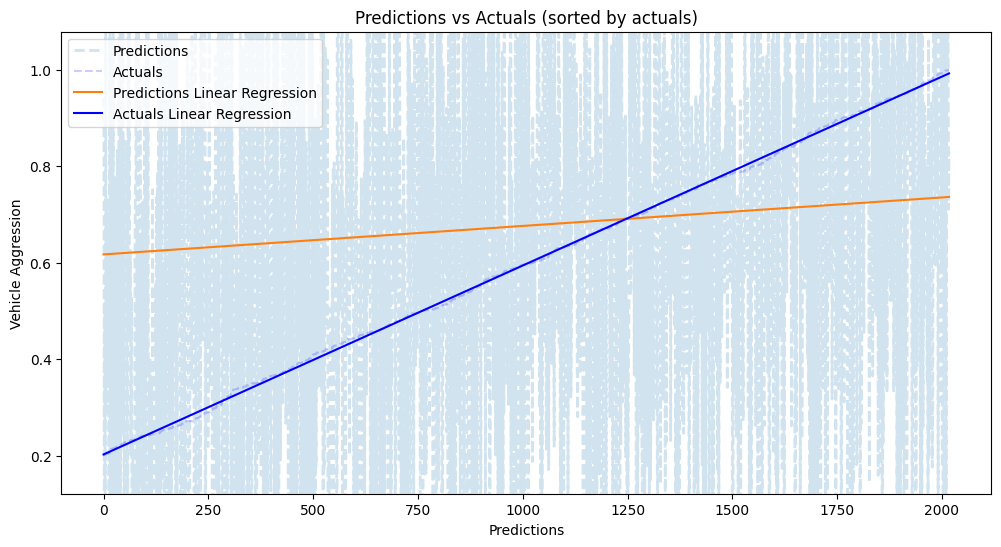

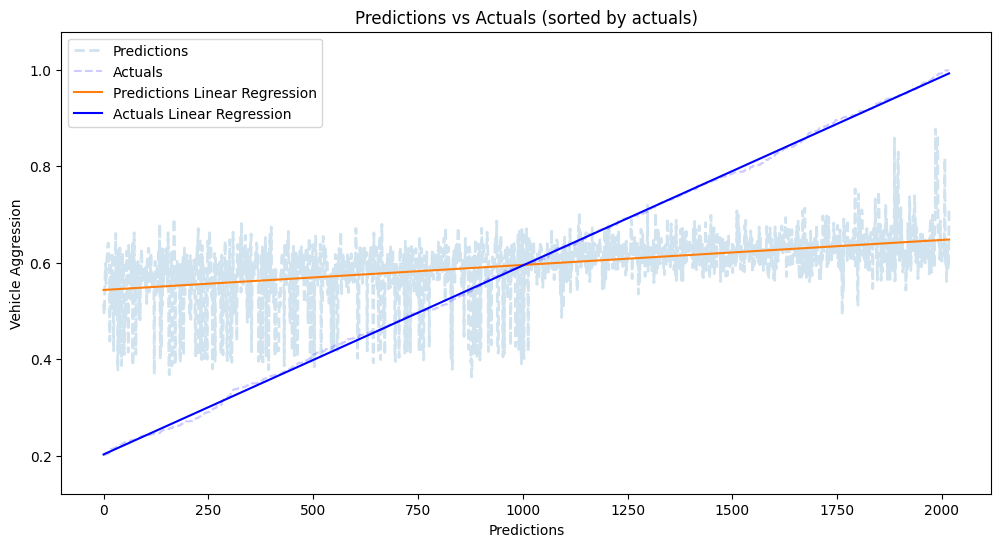

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


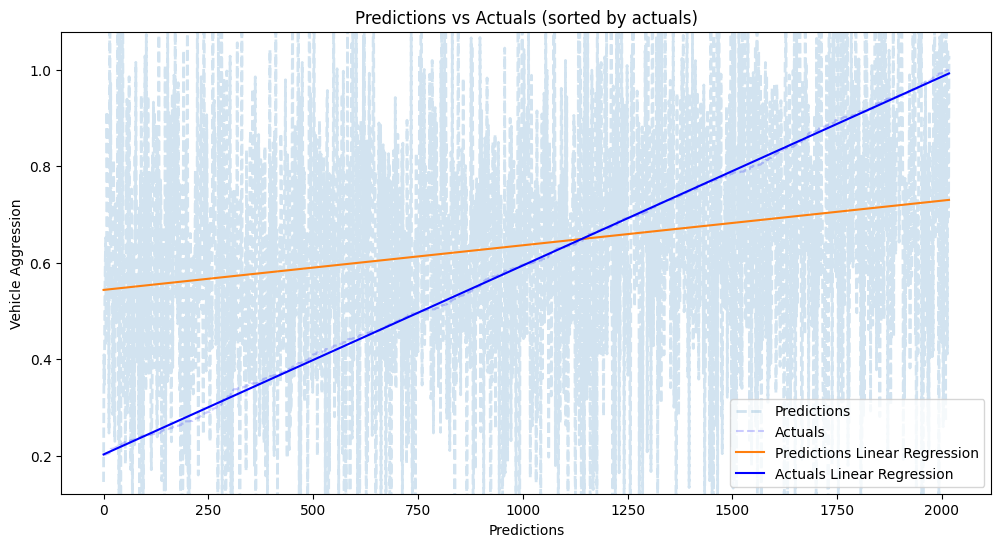

Linear Regression: MSE = 5.8010, R2 = -110.2640
Random Forest: MSE = 0.0425, R2 = 0.1839
Support Vector Regression: MSE = 0.1176, R2 = -1.2552


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR 
from sklearn.metrics import mean_squared_error, r2_score
import time

# Linear Regression
lr = LinearRegression()
time_start = time.perf_counter()
lr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_lr = lr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_lr)
add_best_of_model('Linear Regression', y_pred_lr, training_time=time_end-time_start)

# Random Forest
n_estimators = 200
random_state = 42
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=-1)
# Start timer
time_start = time.perf_counter()
rf.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_rf = rf.predict(X_test_2d)
plot_evaluation(y_test, y_pred_rf)
add_best_of_model('Random Forest', y_pred_rf, training_time=time_end-time_start, hyperparameters={'n_estimators': n_estimators, 'random_state': random_state})

# Support Vector Regression
max_iter = 10000
svr = LinearSVR(max_iter=max_iter)
time_start = time.perf_counter()
svr.fit(X_train_2d, y_train)
time_end = time.perf_counter()
y_pred_svr = svr.predict(X_test_2d)
plot_evaluation(y_test, y_pred_svr)
add_best_of_model('Linear SVR', y_pred_svr, training_time=time_end-time_start, hyperparameters={'max_iter': max_iter})

# Evaluation
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Linear Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_lr, r2_lr))
print("Random Forest: MSE = {:.4f}, R2 = {:.4f}".format(mse_rf, r2_rf))
print("Support Vector Regression: MSE = {:.4f}, R2 = {:.4f}".format(mse_svr, r2_svr))


In [9]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import optuna
from random import choice

# Prepare the dataset
train_data = lgb.Dataset(X_train_2d, label=y_train, free_raw_data=False)
test_data = lgb.Dataset(X_test_2d, label=y_test, reference=train_data, free_raw_data=False)

def train_and_eval_lgb(
    boosting_type: str = 'gbdt',
    early_stopping_rounds: int = 50,
    num_boost_round: int = 2000,
    learning_rate: float = None):
    # Set up the model parameters
    params = {
        'boosting_type': boosting_type,
        'objective': 'regression',
        'metric': 'mse',
        'device_type': 'gpu',
        'n_jobs': -1,
        'early_stopping_rounds': early_stopping_rounds,
        'num_boost_round': num_boost_round,
    }
    if learning_rate is not None:
        params['learning_rate'] = learning_rate
    
    evals_result = {}

    # Train the model
    callback = lgb.record_evaluation(evals_result)
    time_start = time.perf_counter()
    gbm = lgb.train(params, train_data, valid_sets=test_data, callbacks=[callback])
    time_end = time.perf_counter()
    duration = time_end - time_start

    # Make predictions
    y_pred_lgb = gbm.predict(X_test_2d)

    return evals_result, y_pred_lgb, duration, params

results = {}
for boosting_type in ['gbdt', 'dart', 'goss']:
    results[boosting_type] = train_and_eval_lgb(boosting_type)

for type, result in results.items():
    mse_lgb = mean_squared_error(y_test, result[1])
    mae_lgb = mean_absolute_error(y_test, result[1])
    r2_lgb = r2_score(y_test, result[1])
    print("LightGBM {} Regression: MSE = {:.4f}, R2 = {:.4f}, MAE = {:.4f}".format(type, mse_lgb, r2_lgb, mae_lgb))

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1631745
[LightGBM] [Info] Number of data points in the train set: 8070, number of used features: 6399
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6399 dense feature groups (49.26 MB) transferred to GPU in 0.105969 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 0.598358
[LightGBM] [Info] Increasing preallocd_max_num_wg_ to 1600 for launching more workgroups
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1631745
[LightGBM] [Info] Number of data points in the train set: 8070, number of used features: 6399
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[L

c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1631745
[LightGBM] [Info] Number of data points in the train set: 8070, number of used features: 6399
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4090, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6399 dense feature groups (49.26 MB) transferred to GPU in 0.117379 secs. 0 sparse feature groups
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 0.598358
[LightGBM] [Info] Increasing preallocd_max_num_wg_ to 1600 for launching more workgroups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6399 dense feature groups (14.72 MB) transferred to GPU in 0.113951 secs. 0 sparse feature groups
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 6399 dense feature groups (14.72 MB) transferred to GPU in 0.12

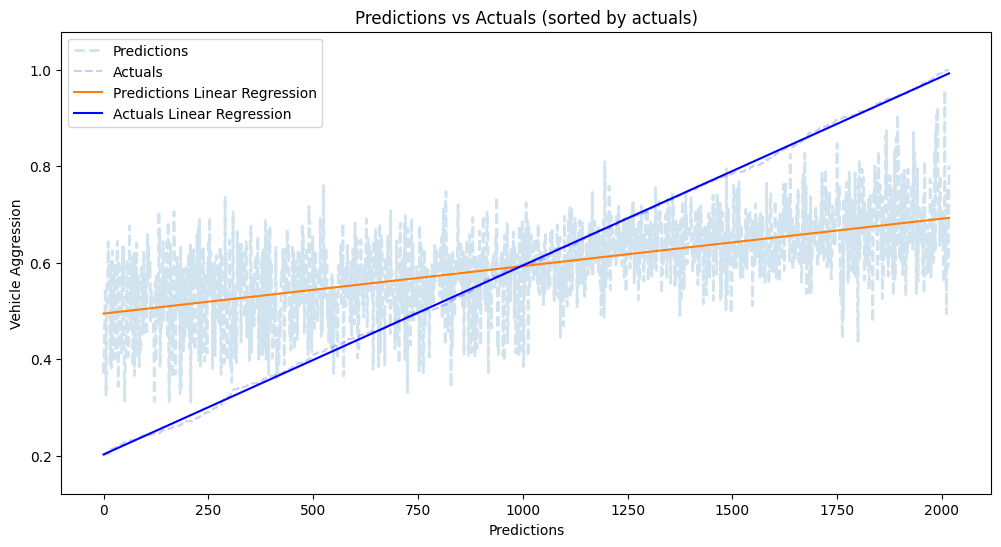

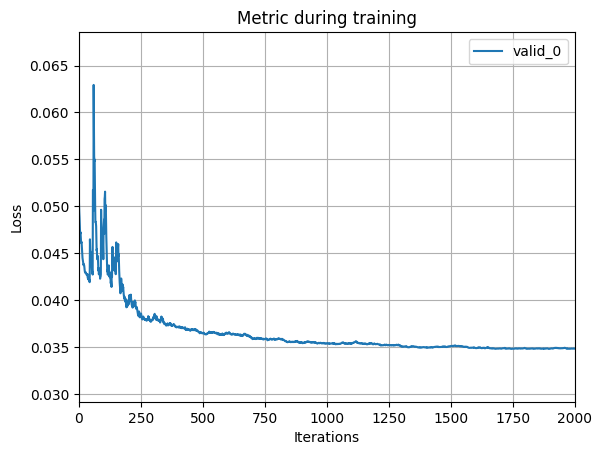

In [10]:
# Select best model
best_result = min(results.items(), key=lambda x: calculate_loss(y_test, x[1][1]))
# Plot the best model
plot_evaluation(y_test, best_result[1][1])
lgb.plot_metric(best_result[1][0], xlabel='Iterations', ylabel='Loss')
best_lgb_predictions = best_result[1][1]
best_booster_type = best_result[0]
loss_at_epoch = best_result[1][0]['valid_0']['l2']
train_duration = best_result[1][2]
params = best_result[1][3]
add_best_of_model(f'LightGBM {best_booster_type}', best_lgb_predictions, loss_at_epoch, train_duration, params)

In [11]:
import torch.nn as nn

class CNNRegressor(nn.Module):
    def __init__(self, n_features, seq_length, n_outputs, n_filters=32, kernel_size=3, pool_size=2, dropout_rate=0.5, hidden_layers=64):
        super(CNNRegressor, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(n_features, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Conv1d(n_filters, n_filters, kernel_size),
            nn.ReLU(),
            nn.MaxPool1d(pool_size),
            nn.Dropout(dropout_rate),
            nn.Flatten(),
        )

        self.fc = nn.Sequential(
            nn.Linear(n_filters * ((seq_length - 2*kernel_size)//pool_size**2), hidden_layers),
            nn.ReLU(),
            nn.Linear(hidden_layers, n_outputs)
        )

    def forward(self, x):
        x = x.transpose(1, 2)  # swap time and feature dimensions
        x = self.cnn(x)
        x = self.fc(x)
        return x

In [12]:
class RNNRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNNRegressor, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
        return hidden

In [13]:
import math

# Define the Dense Layer (Bottleneck layer)
class DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseLayer, self).__init__()
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.conv1 = nn.Conv1d(in_channels, 4*growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(4*growth_rate)
        self.conv2 = nn.Conv1d(4*growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        # print(f'Before x.shape: {x.shape}')
        out = self.conv1(torch.relu(self.bn1(x)))
        # print(f'Conv1 out.shape: {out.shape}')
        out = self.conv2(torch.relu(self.bn2(out)))
        # print(f'Conv2 out.shape: {out.shape}')
        out = torch.cat([out,x], 1)
        # print(f'Final out.shape: {out.shape}')
        return out

# Define the Dense Block
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate, n_layers):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList([DenseLayer(in_channels + i*growth_rate, growth_rate) for i in range(n_layers)])

    def forward(self, x):
        for layer in self.layers:
            # print(f'Before x.shape: {x.shape}')
            x = layer(x)
            # print(f'After x.shape: {x.shape}')
        return x

# Define the Transition Layer
class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.bn = nn.BatchNorm1d(in_channels)
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size=1, bias=False)
        self.avg_pool = nn.AvgPool1d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv(torch.relu(self.bn(x)))
        return self.avg_pool(out)

class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_init_features=64, output_size=1):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_planes = 2*growth_rate
        self.conv1 = nn.Conv1d(X_train.shape[1], num_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.dense_blocks = nn.ModuleList()
        self.trans_layers = nn.ModuleList()

        for i in range(len(nblocks)):
            self.dense_blocks.append(self._make_dense_layers(block, num_planes, nblocks[i]))
            num_planes += nblocks[i]*growth_rate
            if i != len(nblocks) - 1:
                out_planes = int(math.floor(num_planes*reduction))
                self.trans_layers.append(TransitionLayer(num_planes, out_planes))
                num_planes = out_planes

        self.bn = nn.BatchNorm1d(num_planes).to(device)
        self.linear = nn.Linear(num_planes, output_size).to(device)

    def _make_dense_layers(self, block, in_planes, nblock):
        return nn.Sequential(*block(in_planes, self.growth_rate, n_layers=nblock).layers)

    def forward(self, x):
        # print(f'Input: {x.shape}')
        out = self.conv1(x)
        for i, (dense_block, trans_layer) in enumerate(zip(self.dense_blocks, self.trans_layers)):
            # print(f'Before dense_blocks[{i}]: {out.shape}')
            out = dense_block(out)
            # print(f'After dense_blocks[{i}]: {out.shape}')
            out = trans_layer(out)
            # print(f'After trans_layers[{i}]: {out.shape}')
        out = self.dense_blocks[-1](out)
        # print(f'After dense_blocks[-1]: {out.shape}')
        out = torch.relu(self.bn(out))
        out = nn.functional.adaptive_avg_pool1d(out, 1)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
import optuna
import random
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train(
    net: nn.Module, 
    criterion, 
    optimizer: optim.Optimizer,
    num_epochs: int, 
    train_loader: DataLoader, 
    device: str, 
    trial: optuna.Trial, 
    early_stopping_rounds: int = -1):
    net.train()
    loss_at_epoch = []
    best_loss = float('inf')
    start_time = time.perf_counter()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        loss_at_epoch.append(epoch_loss)

        trial.report(max(best_loss, epoch_loss), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        epsilon = 1e-3
        if epoch_loss + epsilon < best_loss:
            print(f'Epoch {epoch} loss improved from {best_loss:.4f} to {epoch_loss:.4f}!')
            best_loss = epoch_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f'Epoch {epoch} loss did not improve from {best_loss:.4f}! Remaining epochs: {early_stopping_rounds - epochs_no_improve}')
            if epochs_no_improve == early_stopping_rounds:
                print('Early stopping!')
                end_time = time.perf_counter()
                plot_train(loss_at_epoch)
                return net, loss_at_epoch, end_time - start_time

    end_time = time.perf_counter()
    # Plot the loss at each epoch
    plot_train(loss_at_epoch)
    return net, loss_at_epoch, end_time - start_time

def evaluate(net: nn.Module, criterion, test_loader: DataLoader, device: str):
    net.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        test_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.float().to(device), labels.float().to(device)
            outputs = net(inputs)

            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())
            
    plot_evaluation(actuals, predictions)

    return predictions, actuals, test_loss/len(test_loader)

In [32]:
import os

def train_and_eval_dnn(trial: optuna.Trial):
    growth_rate = trial.suggest_int('growth_rate', 4, 12)
    reduction = trial.suggest_float('reduction', 0.5, 0.9)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    nblocks = [trial.suggest_int('nblocks1', 4, 8),
               trial.suggest_int('nblocks2', 8, 16),
               trial.suggest_int('nblocks3', 16, 32),]

    net = DenseNet(DenseBlock, nblocks, growth_rate=growth_rate, reduction=reduction, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 2000

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=30)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)
    
    # Export model to ONNX
    export_path = '../model/export'
    os.makedirs(export_path, exist_ok=True)
    onnx_path = f'{export_path}/dnn_{trial.number}.onnx'
    torch.onnx.export(net, test_loader, onnx_path, verbose=True)

    return test_loss

In [33]:
def train_and_eval_rnn(trial: optuna.Trial):
    # Hyperparameters
    input_size = X_train.shape[2]
    output_size = 1
    sequence_length = X_train.shape[1]
    
    num_layers = trial.suggest_int('growth_rate', 16, 128, step=8)
    hidden_size = trial.suggest_int('growth_rate', 12, 48, step=4)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.5, step=0.05)
    
    print(f'X_train.shape: {X_train.shape}')
    
    model = RNNRegressor(input_size, output_size, hidden_size, num_layers).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    num_epochs = 40

    model, loss_at_epoch, duration = train(model, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=5)
    predictions, actuals, test_loss = evaluate(model, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

In [34]:
def train_and_eval_cnn(trial: optuna.Trial): # Suggest hyperparameters using the trial object
    num_filters = trial.suggest_int("num_filters", 64, 512, step=32)
    kernel_size = trial.suggest_int("kernel_size", 3, 3)
    pool_size = trial.suggest_int("pool_size", 2, 2)
    hidden_layers = trial.suggest_int("hidden_layers", 24, 92, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3, step=0.05)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    # num_filters = 437
    # kernel_size = 4
    # pool_size = 4
    # hidden_units = 73
    # dropout_rate = 0.1657660256105821
    # learning_rate = 3.964884325777312e-05
    
    print(f'X_train.shape: {X_train.shape}')
    input_channels = X_train.shape[2]
    sequence_length = X_train.shape[1]
    n_outputs = 1
    net = CNNRegressor(input_channels, sequence_length, n_outputs, num_filters, kernel_size, pool_size, dropout_rate, hidden_layers).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    num_epochs = 400

    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=15)
    predictions, actuals, test_loss = evaluate(net, criterion, test_loader, device)
    
    trial.set_user_attr('predictions', predictions)
    trial.set_user_attr('loss_at_epoch', loss_at_epoch)
    trial.set_user_attr('duration', duration)

    return test_loss

## Hyperparameter optimization via Optuna

In [35]:
def optimize_model(model_name: str, train_and_eval_func, n_trials: int):
    study = optuna.create_study(
        study_name=f'{model_name} Optimization',
        direction="minimize", 
        sampler=optuna.samplers.TPESampler(seed=42), 
        pruner=optuna.pruners.PercentilePruner(percentile=25, n_warmup_steps=20)
        )
    study.optimize(train_and_eval_func, n_trials=n_trials)
    
    # Get the best 5 trials
    completed_trials = study.get_trials(deepcopy=False, states=[optuna.trial.TrialState.COMPLETE])
    best_trials = sorted(completed_trials, key=lambda t: t.value)[:5]

    # Print the best 5 trials' parameters and their respective values
    for i, trial in enumerate(best_trials):
        print(f"Best trial {i + 1}:")
        print(f"\tValue: {trial.value}")
        print(f"\tParams: {trial.params}")
        
    # Get the best trial
    best_trial = study.best_trial
    # Add best trial to the best of models
    add_best_of_model(
        model_name, 
        best_trial.user_attrs['predictions'],
        best_trial.user_attrs['loss_at_epoch'],
        best_trial.user_attrs['duration'],
        best_trial.params)

[I 2023-07-28 22:10:04,687] A new study created in memory with name: DNN Optimization


Epoch 0 loss improved from inf to 0.0742!
Epoch 1 loss improved from 0.0742 to 0.0506!
Epoch 2 loss improved from 0.0506 to 0.0495!
Epoch 3 loss improved from 0.0495 to 0.0457!
Epoch 4 loss improved from 0.0457 to 0.0444!
Epoch 5 loss improved from 0.0444 to 0.0381!
Epoch 6 loss improved from 0.0381 to 0.0340!
Epoch 7 loss improved from 0.0340 to 0.0297!
Epoch 8 loss improved from 0.0297 to 0.0228!
Epoch 9 loss improved from 0.0228 to 0.0198!
Epoch 10 loss did not improve from 0.0198! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0198! Remaining epochs: 28
Epoch 12 loss improved from 0.0198 to 0.0173!
Epoch 13 loss improved from 0.0173 to 0.0145!
Epoch 14 loss did not improve from 0.0145! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0145! Remaining epochs: 28
Epoch 16 loss improved from 0.0145 to 0.0107!
Epoch 17 loss improved from 0.0107 to 0.0090!
Epoch 18 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 19 loss did not improve from 0.0090! Remain

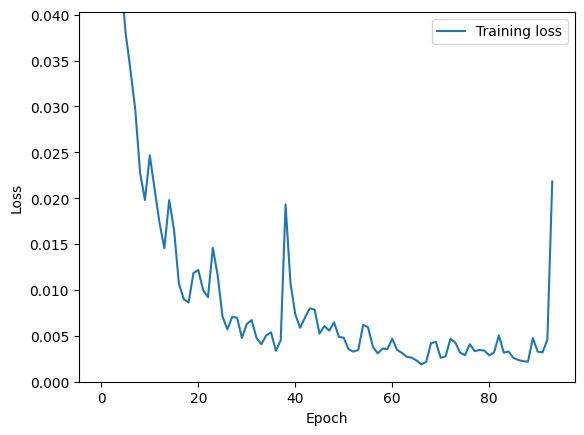

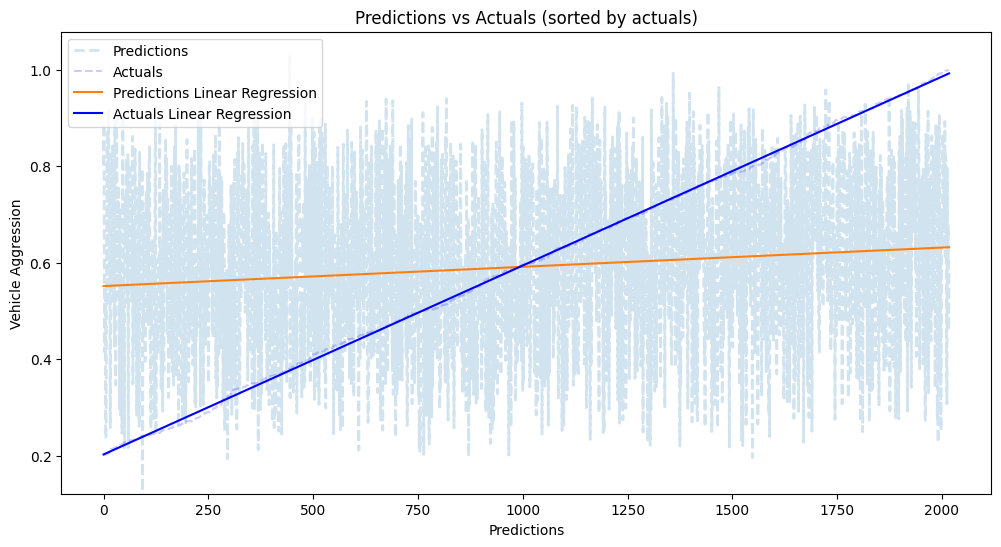

[I 2023-07-28 22:12:37,705] Trial 0 finished with value: 0.0752330208197236 and parameters: {'growth_rate': 7, 'reduction': 0.8802857225639664, 'learning_rate': 0.0029106359131330704, 'nblocks1': 6, 'nblocks2': 9, 'nblocks3': 18}. Best is trial 0 with value: 0.0752330208197236.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0656!
Epoch 1 loss improved from 0.0656 to 0.0529!
Epoch 2 loss improved from 0.0529 to 0.0489!
Epoch 3 loss did not improve from 0.0489! Remaining epochs: 29
Epoch 4 loss improved from 0.0489 to 0.0475!
Epoch 5 loss improved from 0.0475 to 0.0443!
Epoch 6 loss improved from 0.0443 to 0.0411!
Epoch 7 loss improved from 0.0411 to 0.0355!
Epoch 8 loss did not improve from 0.0355! Remaining epochs: 29
Epoch 9 loss improved from 0.0355 to 0.0306!
Epoch 10 loss improved from 0.0306 to 0.0278!
Epoch 11 loss improved from 0.0278 to 0.0263!
Epoch 12 loss improved from 0.0263 to 0.0236!
Epoch 13 loss improved from 0.0236 to 0.0220!
Epoch 14 loss improved from 0.0220 to 0.0188!
Epoch 15 loss did not improve from 0.0188! Remaining epochs: 29
Epoch 16 loss did not

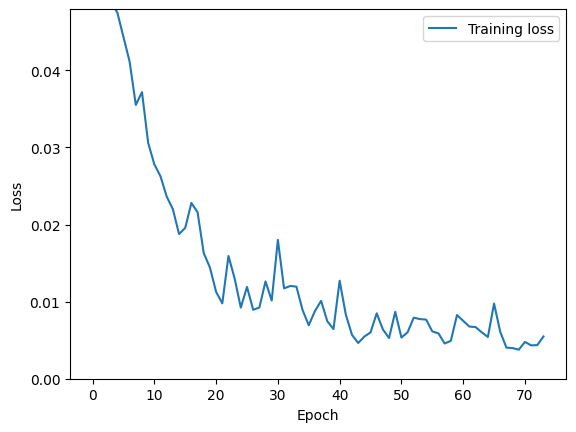

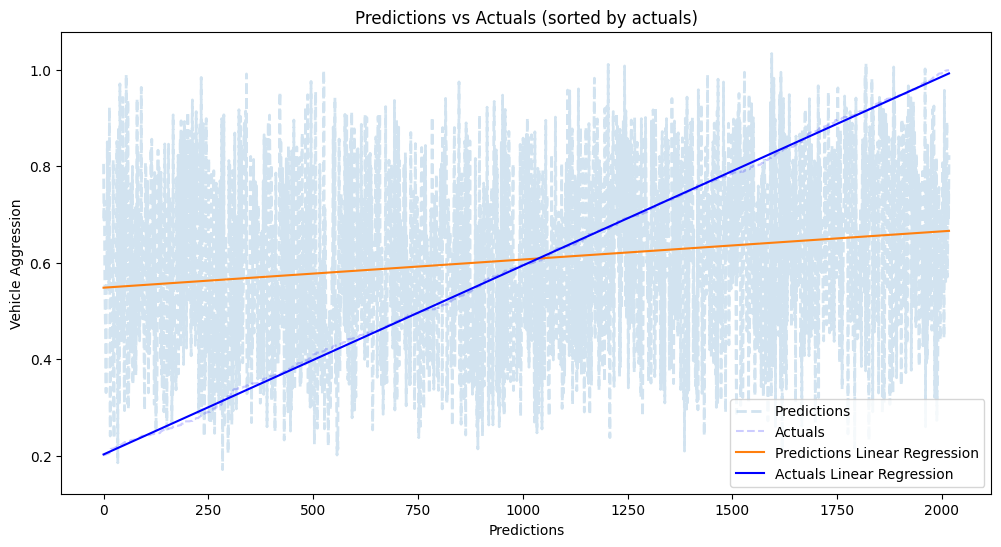

[I 2023-07-28 22:15:12,976] Trial 1 finished with value: 0.07414165884256363 and parameters: {'growth_rate': 4, 'reduction': 0.846470458309974, 'learning_rate': 0.0015930522616241021, 'nblocks1': 7, 'nblocks2': 8, 'nblocks3': 32}. Best is trial 1 with value: 0.07414165884256363.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0968!
Epoch 1 loss improved from 0.0968 to 0.0493!
Epoch 2 loss improved from 0.0493 to 0.0450!
Epoch 3 loss improved from 0.0450 to 0.0410!
Epoch 4 loss improved from 0.0410 to 0.0345!
Epoch 5 loss improved from 0.0345 to 0.0331!
Epoch 6 loss improved from 0.0331 to 0.0295!
Epoch 7 loss did not improve from 0.0295! Remaining epochs: 29
Epoch 8 loss improved from 0.0295 to 0.0249!
Epoch 9 loss improved from 0.0249 to 0.0211!
Epoch 10 loss improved from 0.0211 to 0.0177!
Epoch 11 loss did not improve from 0.0177! Remaining epochs: 29
Epoch 12 loss did not improve from 0.0177! Remaining epochs: 28
Epoch 13 loss improved from 0.0177 to 0.0161!
Epoch 14 loss improved from 0.0161 to 0.0123!
Epoch 15 loss did not improve from 0.0123! Remaining epochs: 29
Epo

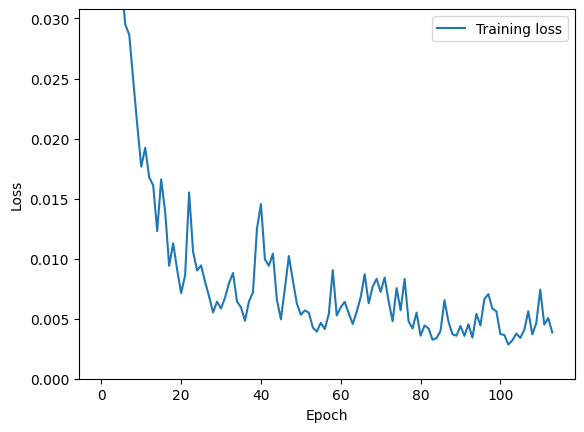

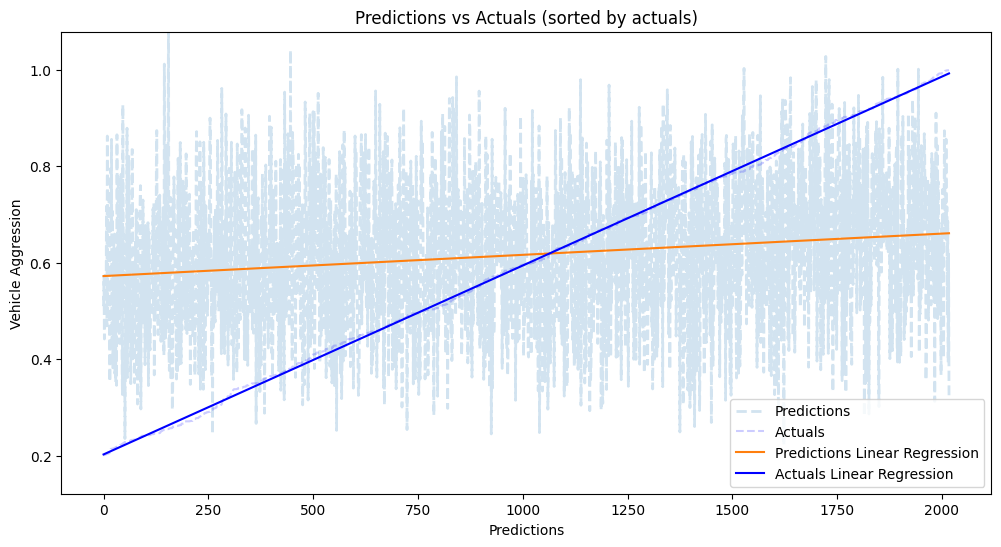

[I 2023-07-28 22:18:50,850] Trial 2 finished with value: 0.06578482338227332 and parameters: {'growth_rate': 11, 'reduction': 0.5849356442713105, 'learning_rate': 0.0002310201887845295, 'nblocks1': 4, 'nblocks2': 10, 'nblocks3': 24}. Best is trial 2 with value: 0.06578482338227332.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0643!
Epoch 1 loss improved from 0.0643 to 0.0510!
Epoch 2 loss improved from 0.0510 to 0.0486!
Epoch 3 loss improved from 0.0486 to 0.0438!
Epoch 4 loss improved from 0.0438 to 0.0421!
Epoch 5 loss improved from 0.0421 to 0.0373!
Epoch 6 loss improved from 0.0373 to 0.0327!
Epoch 7 loss improved from 0.0327 to 0.0298!
Epoch 8 loss improved from 0.0298 to 0.0233!
Epoch 9 loss improved from 0.0233 to 0.0215!
Epoch 10 loss did not improve from 0.0215! Remaining epochs: 29
Epoch 11 loss improved from 0.0215 to 0.0174!
Epoch 12 loss improved from 0.0174 to 0.0127!
Epoch 13 loss did not improve from 0.0127! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0127! Remaining epochs: 28
Epoch 15 loss did not improve from 0.0127! Remaining epochs: 27
Epo

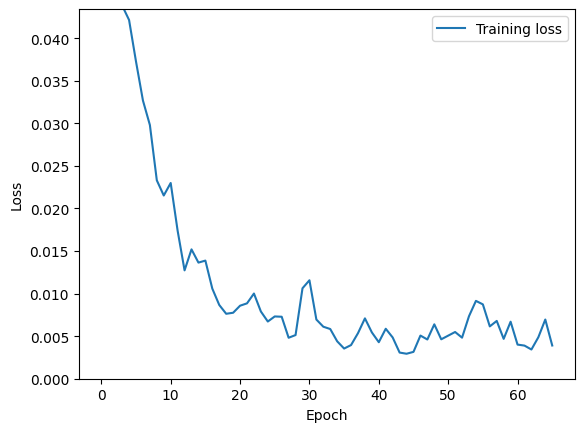

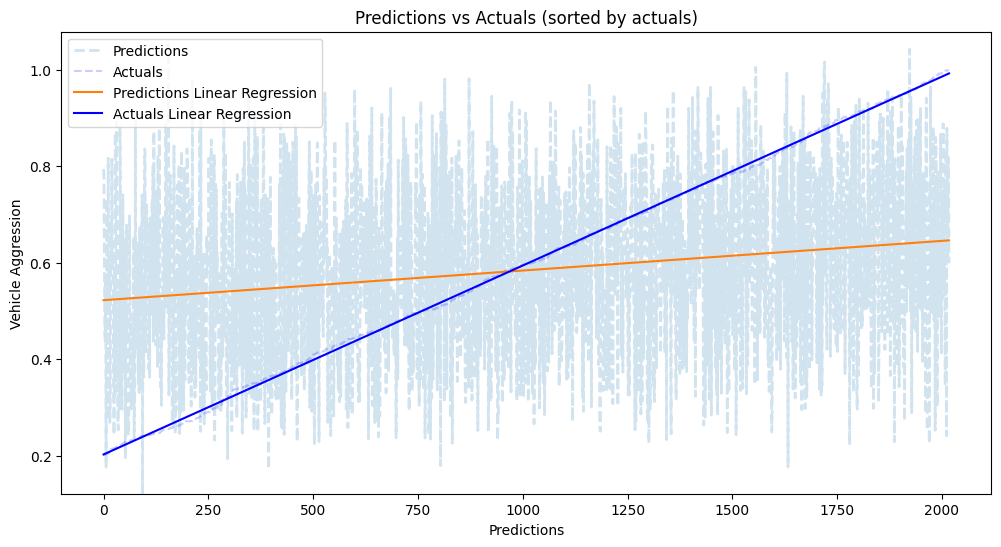

[I 2023-07-28 22:20:51,281] Trial 3 finished with value: 0.06891191401518881 and parameters: {'growth_rate': 7, 'reduction': 0.6164916560792167, 'learning_rate': 0.0016738085788752138, 'nblocks1': 4, 'nblocks2': 10, 'nblocks3': 22}. Best is trial 2 with value: 0.06578482338227332.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0650!
Epoch 1 loss improved from 0.0650 to 0.0487!
Epoch 2 loss improved from 0.0487 to 0.0431!
Epoch 3 loss improved from 0.0431 to 0.0375!
Epoch 4 loss improved from 0.0375 to 0.0350!
Epoch 5 loss improved from 0.0350 to 0.0326!
Epoch 6 loss improved from 0.0326 to 0.0308!
Epoch 7 loss improved from 0.0308 to 0.0243!
Epoch 8 loss did not improve from 0.0243! Remaining epochs: 29
Epoch 9 loss improved from 0.0243 to 0.0189!
Epoch 10 loss improved from 0.0189 to 0.0151!
Epoch 11 loss did not improve from 0.0151! Remaining epochs: 29
Epoch 12 loss did not improve from 0.0151! Remaining epochs: 28
Epoch 13 loss improved from 0.0151 to 0.0139!
Epoch 14 loss did not improve from 0.0139! Remaining epochs: 29
Epoch 15 loss improved from 0.0139 to 0.0114!
Epo

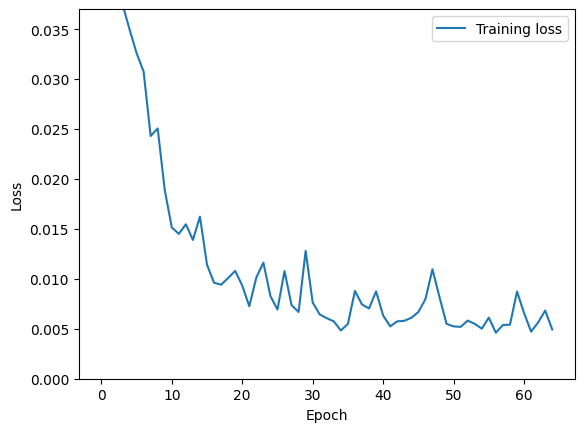

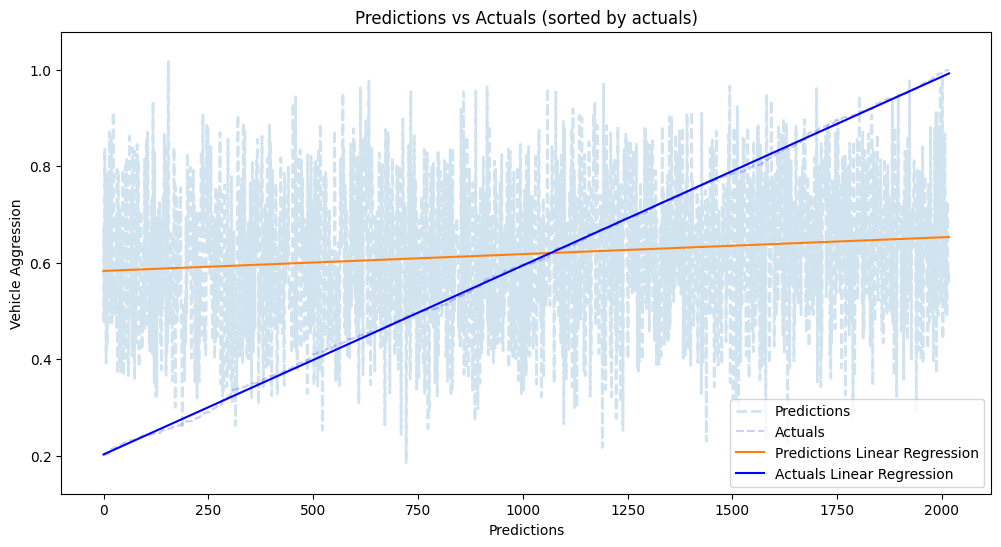

[I 2023-07-28 22:22:40,510] Trial 4 finished with value: 0.06743528530932963 and parameters: {'growth_rate': 8, 'reduction': 0.8140703845572055, 'learning_rate': 0.00025081156860452336, 'nblocks1': 6, 'nblocks2': 13, 'nblocks3': 16}. Best is trial 2 with value: 0.06578482338227332.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.1496!
Epoch 1 loss improved from 0.1496 to 0.0522!
Epoch 2 loss improved from 0.0522 to 0.0496!
Epoch 3 loss improved from 0.0496 to 0.0470!
Epoch 4 loss improved from 0.0470 to 0.0457!
Epoch 5 loss improved from 0.0457 to 0.0411!
Epoch 6 loss improved from 0.0411 to 0.0375!
Epoch 7 loss improved from 0.0375 to 0.0327!
Epoch 8 loss improved from 0.0327 to 0.0308!
Epoch 9 loss improved from 0.0308 to 0.0275!
Epoch 10 loss improved from 0.0275 to 0.0212!
Epoch 11 loss did not improve from 0.0212! Remaining epochs: 29
Epoch 12 loss improved from 0.0212 to 0.0197!
Epoch 13 loss improved from 0.0197 to 0.0177!
Epoch 14 loss did not improve from 0.0177! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0177! Remaining epochs: 28
Epoch 16 loss improve

[I 2023-07-28 22:23:33,480] Trial 5 pruned. 


Epoch 0 loss improved from inf to 0.0897!
Epoch 1 loss improved from 0.0897 to 0.0512!
Epoch 2 loss did not improve from 0.0512! Remaining epochs: 29
Epoch 3 loss improved from 0.0512 to 0.0494!
Epoch 4 loss improved from 0.0494 to 0.0464!
Epoch 5 loss improved from 0.0464 to 0.0431!
Epoch 6 loss improved from 0.0431 to 0.0414!
Epoch 7 loss improved from 0.0414 to 0.0361!
Epoch 8 loss improved from 0.0361 to 0.0334!
Epoch 9 loss improved from 0.0334 to 0.0277!
Epoch 10 loss improved from 0.0277 to 0.0233!
Epoch 11 loss did not improve from 0.0233! Remaining epochs: 29
Epoch 12 loss did not improve from 0.0233! Remaining epochs: 28
Epoch 13 loss improved from 0.0233 to 0.0220!
Epoch 14 loss improved from 0.0220 to 0.0160!
Epoch 15 loss improved from 0.0160 to 0.0130!
Epoch 16 loss improved from 0.0130 to 0.0116!
Epoch 17 loss did not improve from 0.0116! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0116! Remaining epochs: 28
Epoch 19 loss did not improve from 0.0116! Remain

[I 2023-07-28 22:24:12,105] Trial 6 pruned. 


Epoch 0 loss improved from inf to 0.0824!
Epoch 1 loss improved from 0.0824 to 0.0497!
Epoch 2 loss improved from 0.0497 to 0.0466!
Epoch 3 loss improved from 0.0466 to 0.0451!
Epoch 4 loss improved from 0.0451 to 0.0411!
Epoch 5 loss improved from 0.0411 to 0.0391!
Epoch 6 loss did not improve from 0.0391! Remaining epochs: 29
Epoch 7 loss improved from 0.0391 to 0.0369!
Epoch 8 loss improved from 0.0369 to 0.0351!
Epoch 9 loss improved from 0.0351 to 0.0323!
Epoch 10 loss improved from 0.0323 to 0.0303!
Epoch 11 loss improved from 0.0303 to 0.0280!
Epoch 12 loss improved from 0.0280 to 0.0233!
Epoch 13 loss improved from 0.0233 to 0.0210!
Epoch 14 loss improved from 0.0210 to 0.0195!
Epoch 15 loss did not improve from 0.0195! Remaining epochs: 29
Epoch 16 loss did not improve from 0.0195! Remaining epochs: 28
Epoch 17 loss did not improve from 0.0195! Remaining epochs: 27
Epoch 18 loss improved from 0.0195 to 0.0177!
Epoch 19 loss did not improve from 0.0177! Remaining epochs: 29


[I 2023-07-28 22:24:51,381] Trial 7 pruned. 


Epoch 0 loss improved from inf to 0.1294!
Epoch 1 loss improved from 0.1294 to 0.0590!
Epoch 2 loss did not improve from 0.0590! Remaining epochs: 29
Epoch 3 loss improved from 0.0590 to 0.0551!
Epoch 4 loss improved from 0.0551 to 0.0503!
Epoch 5 loss did not improve from 0.0503! Remaining epochs: 29
Epoch 6 loss did not improve from 0.0503! Remaining epochs: 28
Epoch 7 loss improved from 0.0503 to 0.0471!
Epoch 8 loss improved from 0.0471 to 0.0450!
Epoch 9 loss improved from 0.0450 to 0.0412!
Epoch 10 loss did not improve from 0.0412! Remaining epochs: 29
Epoch 11 loss improved from 0.0412 to 0.0352!
Epoch 12 loss improved from 0.0352 to 0.0284!
Epoch 13 loss improved from 0.0284 to 0.0259!
Epoch 14 loss improved from 0.0259 to 0.0232!
Epoch 15 loss did not improve from 0.0232! Remaining epochs: 29
Epoch 16 loss improved from 0.0232 to 0.0175!
Epoch 17 loss improved from 0.0175 to 0.0153!
Epoch 18 loss did not improve from 0.0153! Remaining epochs: 29
Epoch 19 loss did not improve f

[I 2023-07-28 22:25:42,304] Trial 8 pruned. 


Epoch 0 loss improved from inf to 0.1477!
Epoch 1 loss improved from 0.1477 to 0.0487!
Epoch 2 loss improved from 0.0487 to 0.0452!
Epoch 3 loss improved from 0.0452 to 0.0400!
Epoch 4 loss improved from 0.0400 to 0.0362!
Epoch 5 loss improved from 0.0362 to 0.0327!
Epoch 6 loss improved from 0.0327 to 0.0254!
Epoch 7 loss improved from 0.0254 to 0.0221!
Epoch 8 loss improved from 0.0221 to 0.0187!
Epoch 9 loss improved from 0.0187 to 0.0175!
Epoch 10 loss improved from 0.0175 to 0.0150!
Epoch 11 loss did not improve from 0.0150! Remaining epochs: 29
Epoch 12 loss did not improve from 0.0150! Remaining epochs: 28
Epoch 13 loss did not improve from 0.0150! Remaining epochs: 27
Epoch 14 loss improved from 0.0150 to 0.0138!
Epoch 15 loss improved from 0.0138 to 0.0122!
Epoch 16 loss improved from 0.0122 to 0.0097!
Epoch 17 loss did not improve from 0.0097! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0097! Remaining epochs: 28
Epoch 19 loss did not improve from 0.0097! Remain

[I 2023-07-28 22:26:18,769] Trial 9 pruned. 


Epoch 0 loss improved from inf to 0.0985!
Epoch 1 loss improved from 0.0985 to 0.0480!
Epoch 2 loss did not improve from 0.0480! Remaining epochs: 29
Epoch 3 loss improved from 0.0480 to 0.0437!
Epoch 4 loss improved from 0.0437 to 0.0364!
Epoch 5 loss improved from 0.0364 to 0.0294!
Epoch 6 loss improved from 0.0294 to 0.0240!
Epoch 7 loss improved from 0.0240 to 0.0195!
Epoch 8 loss did not improve from 0.0195! Remaining epochs: 29
Epoch 9 loss improved from 0.0195 to 0.0179!
Epoch 10 loss improved from 0.0179 to 0.0145!
Epoch 11 loss improved from 0.0145 to 0.0121!
Epoch 12 loss improved from 0.0121 to 0.0090!
Epoch 13 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0090! Remaining epochs: 28
Epoch 15 loss did not improve from 0.0090! Remaining epochs: 27
Epoch 16 loss improved from 0.0090 to 0.0073!
Epoch 17 loss did not improve from 0.0073! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0073! Remaining epochs: 28
Epoch 19 loss

[I 2023-07-28 22:27:15,228] Trial 10 pruned. 


Epoch 0 loss improved from inf to 0.0735!
Epoch 1 loss improved from 0.0735 to 0.0481!
Epoch 2 loss improved from 0.0481 to 0.0411!
Epoch 3 loss improved from 0.0411 to 0.0372!
Epoch 4 loss improved from 0.0372 to 0.0302!
Epoch 5 loss improved from 0.0302 to 0.0276!
Epoch 6 loss improved from 0.0276 to 0.0240!
Epoch 7 loss improved from 0.0240 to 0.0195!
Epoch 8 loss improved from 0.0195 to 0.0153!
Epoch 9 loss improved from 0.0153 to 0.0100!
Epoch 10 loss did not improve from 0.0100! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0100! Remaining epochs: 28
Epoch 12 loss did not improve from 0.0100! Remaining epochs: 27
Epoch 13 loss improved from 0.0100 to 0.0072!
Epoch 14 loss did not improve from 0.0072! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0072! Remaining epochs: 28
Epoch 16 loss did not improve from 0.0072! Remaining epochs: 27
Epoch 17 loss did not improve from 0.0072! Remaining epochs: 26
Epoch 18 loss did not improve from 0.0072! Remaining epochs

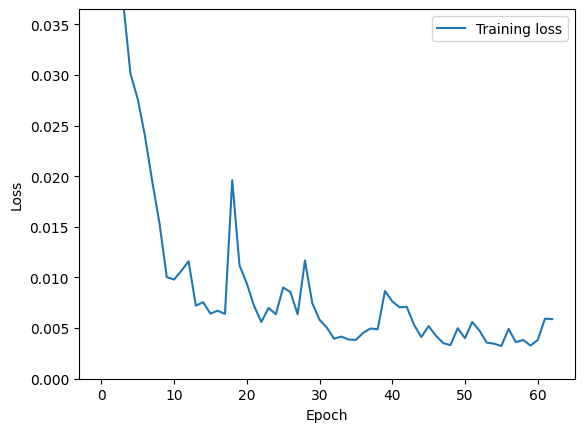

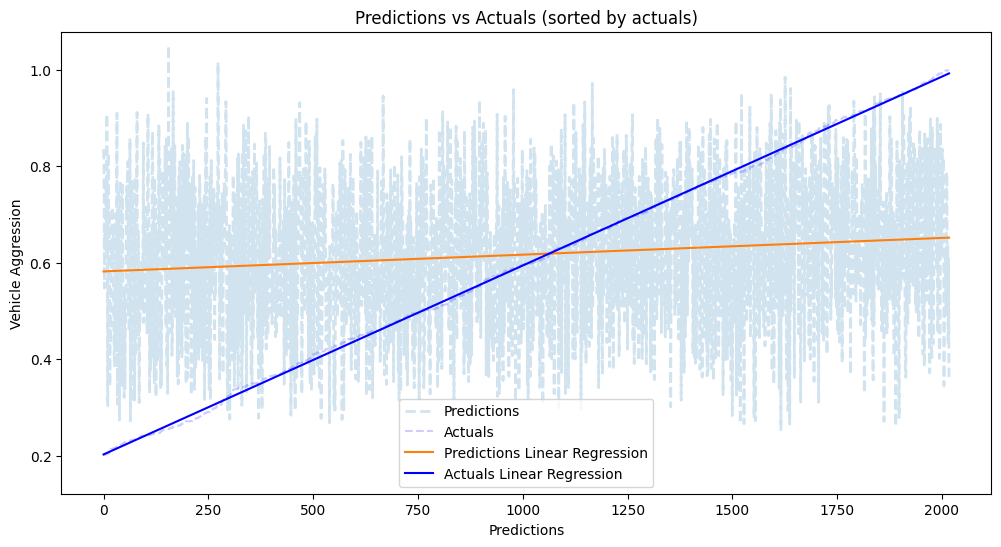

[I 2023-07-28 22:29:00,145] Trial 11 finished with value: 0.0675244671292603 and parameters: {'growth_rate': 12, 'reduction': 0.7545127274101321, 'learning_rate': 0.00033296801117243906, 'nblocks1': 5, 'nblocks2': 13, 'nblocks3': 16}. Best is trial 2 with value: 0.06578482338227332.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0970!
Epoch 1 loss improved from 0.0970 to 0.0482!
Epoch 2 loss improved from 0.0482 to 0.0440!
Epoch 3 loss improved from 0.0440 to 0.0395!
Epoch 4 loss improved from 0.0395 to 0.0362!
Epoch 5 loss improved from 0.0362 to 0.0312!
Epoch 6 loss improved from 0.0312 to 0.0254!
Epoch 7 loss improved from 0.0254 to 0.0222!
Epoch 8 loss improved from 0.0222 to 0.0208!
Epoch 9 loss improved from 0.0208 to 0.0164!
Epoch 10 loss did not improve from 0.0164! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0164! Remaining epochs: 28
Epoch 12 loss did not improve from 0.0164! Remaining epochs: 27
Epoch 13 loss did not improve from 0.0164! Remaining epochs: 26
Epoch 14 loss improved from 0.0164 to 0.0148!
Epoch 15 loss improved from 0.0148 to 0.0119!
Epo

[I 2023-07-28 22:29:43,492] Trial 12 pruned. 


Epoch 0 loss improved from inf to 0.0921!
Epoch 1 loss improved from 0.0921 to 0.0492!
Epoch 2 loss improved from 0.0492 to 0.0456!
Epoch 3 loss improved from 0.0456 to 0.0388!
Epoch 4 loss improved from 0.0388 to 0.0328!
Epoch 5 loss improved from 0.0328 to 0.0254!
Epoch 6 loss improved from 0.0254 to 0.0234!
Epoch 7 loss did not improve from 0.0234! Remaining epochs: 29
Epoch 8 loss improved from 0.0234 to 0.0181!
Epoch 9 loss improved from 0.0181 to 0.0161!
Epoch 10 loss improved from 0.0161 to 0.0133!
Epoch 11 loss did not improve from 0.0133! Remaining epochs: 29
Epoch 12 loss did not improve from 0.0133! Remaining epochs: 28
Epoch 13 loss did not improve from 0.0133! Remaining epochs: 27
Epoch 14 loss improved from 0.0133 to 0.0119!
Epoch 15 loss did not improve from 0.0119! Remaining epochs: 29
Epoch 16 loss improved from 0.0119 to 0.0098!
Epoch 17 loss did not improve from 0.0098! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0098! Remaining epochs: 28
Epoch 19 loss

[I 2023-07-28 22:30:25,014] Trial 13 pruned. 


Epoch 0 loss improved from inf to 0.0719!
Epoch 1 loss improved from 0.0719 to 0.0514!
Epoch 2 loss improved from 0.0514 to 0.0468!
Epoch 3 loss improved from 0.0468 to 0.0431!
Epoch 4 loss improved from 0.0431 to 0.0374!
Epoch 5 loss improved from 0.0374 to 0.0307!
Epoch 6 loss improved from 0.0307 to 0.0219!
Epoch 7 loss did not improve from 0.0219! Remaining epochs: 29
Epoch 8 loss did not improve from 0.0219! Remaining epochs: 28
Epoch 9 loss improved from 0.0219 to 0.0184!
Epoch 10 loss improved from 0.0184 to 0.0145!
Epoch 11 loss improved from 0.0145 to 0.0130!
Epoch 12 loss improved from 0.0130 to 0.0103!
Epoch 13 loss did not improve from 0.0103! Remaining epochs: 29
Epoch 14 loss improved from 0.0103 to 0.0080!
Epoch 15 loss did not improve from 0.0080! Remaining epochs: 29
Epoch 16 loss did not improve from 0.0080! Remaining epochs: 28
Epoch 17 loss improved from 0.0080 to 0.0065!
Epoch 18 loss did not improve from 0.0065! Remaining epochs: 29
Epoch 19 loss improved from 0.0

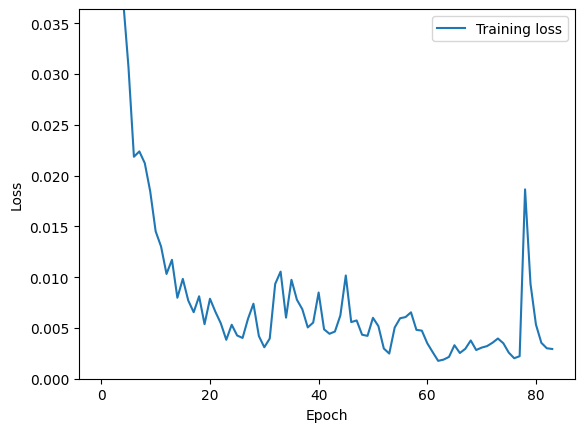

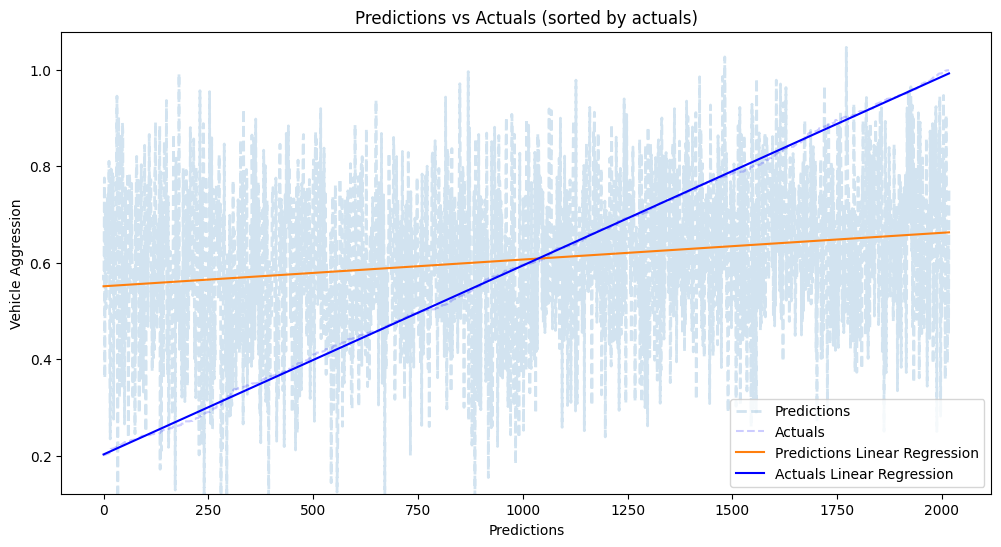

[I 2023-07-28 22:33:01,660] Trial 14 finished with value: 0.06598357646726072 and parameters: {'growth_rate': 10, 'reduction': 0.513434353973789, 'learning_rate': 0.0007131882344152087, 'nblocks1': 8, 'nblocks2': 14, 'nblocks3': 16}. Best is trial 2 with value: 0.06578482338227332.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0719!
Epoch 1 loss improved from 0.0719 to 0.0504!
Epoch 2 loss improved from 0.0504 to 0.0469!
Epoch 3 loss improved from 0.0469 to 0.0426!
Epoch 4 loss improved from 0.0426 to 0.0358!
Epoch 5 loss improved from 0.0358 to 0.0323!
Epoch 6 loss improved from 0.0323 to 0.0311!
Epoch 7 loss improved from 0.0311 to 0.0239!
Epoch 8 loss improved from 0.0239 to 0.0224!
Epoch 9 loss did not improve from 0.0224! Remaining epochs: 29
Epoch 10 loss improved from 0.0224 to 0.0185!
Epoch 11 loss improved from 0.0185 to 0.0151!
Epoch 12 loss improved from 0.0151 to 0.0090!
Epoch 13 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 14 loss improved from 0.0090 to 0.0067!
Epoch 15 loss did not improve from 0.0067! Remaining epochs: 29
Epoch 16 loss improve

[I 2023-07-28 22:34:03,867] Trial 15 pruned. 


Epoch 0 loss improved from inf to 0.0651!
Epoch 1 loss improved from 0.0651 to 0.0528!
Epoch 2 loss improved from 0.0528 to 0.0471!
Epoch 3 loss improved from 0.0471 to 0.0444!
Epoch 4 loss improved from 0.0444 to 0.0404!
Epoch 5 loss improved from 0.0404 to 0.0343!
Epoch 6 loss improved from 0.0343 to 0.0287!
Epoch 7 loss improved from 0.0287 to 0.0249!
Epoch 8 loss improved from 0.0249 to 0.0187!
Epoch 9 loss improved from 0.0187 to 0.0131!
Epoch 10 loss did not improve from 0.0131! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0131! Remaining epochs: 28
Epoch 12 loss improved from 0.0131 to 0.0117!
Epoch 13 loss did not improve from 0.0117! Remaining epochs: 29
Epoch 14 loss improved from 0.0117 to 0.0090!
Epoch 15 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 16 loss improved from 0.0090 to 0.0064!
Epoch 17 loss did not improve from 0.0064! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0064! Remaining epochs: 28
Epoch 19 loss did not improve f

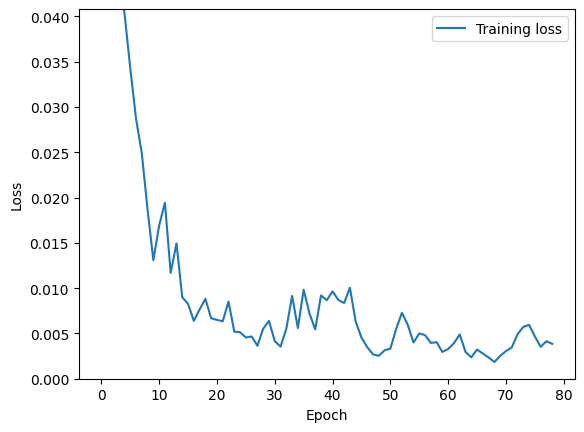

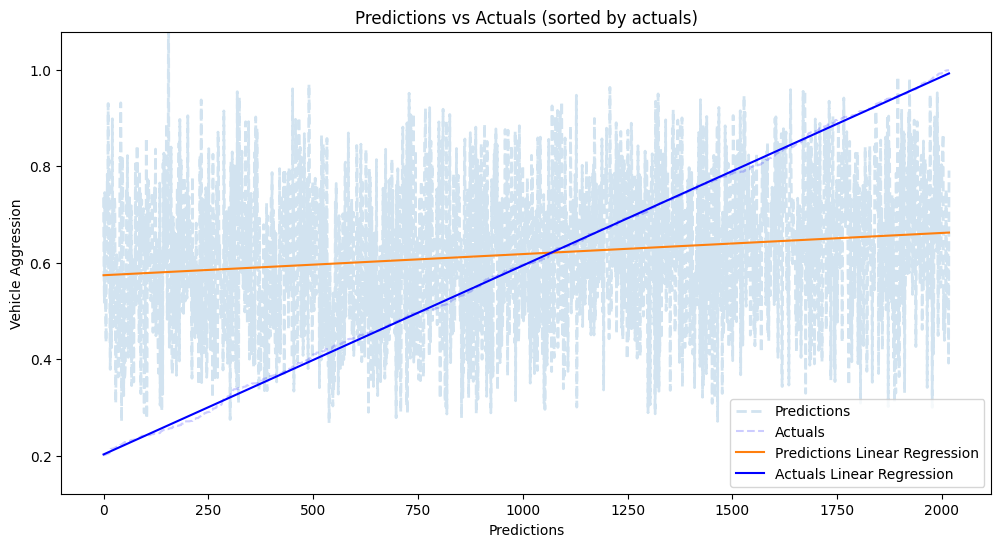

[I 2023-07-28 22:36:58,829] Trial 16 finished with value: 0.06517885229550302 and parameters: {'growth_rate': 11, 'reduction': 0.5029263042620848, 'learning_rate': 0.0006874843852597913, 'nblocks1': 8, 'nblocks2': 11, 'nblocks3': 27}. Best is trial 16 with value: 0.06517885229550302.


============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

Epoch 0 loss improved from inf to 0.0733!
Epoch 1 loss improved from 0.0733 to 0.0486!
Epoch 2 loss improved from 0.0486 to 0.0465!
Epoch 3 loss improved from 0.0465 to 0.0430!
Epoch 4 loss improved from 0.0430 to 0.0397!
Epoch 5 loss improved from 0.0397 to 0.0324!
Epoch 6 loss improved from 0.0324 to 0.0307!
Epoch 7 loss improved from 0.0307 to 0.0283!
Epoch 8 loss improved from 0.0283 to 0.0270!
Epoch 9 loss improved from 0.0270 to 0.0231!
Epoch 10 loss did not improve from 0.0231! Remaining epochs: 29
Epoch 11 loss improved from 0.0231 to 0.0134!
Epoch 12 loss did not improve from 0.0134! Remaining epochs: 29
Epoch 13 loss improved from 0.0134 to 0.0110!
Epoch 14 loss did not improve from 0.0110! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0110! Remaining epochs: 28
Epo

[I 2023-07-28 22:37:52,962] Trial 17 pruned. 


Epoch 0 loss improved from inf to 0.0871!
Epoch 1 loss improved from 0.0871 to 0.0511!
Epoch 2 loss improved from 0.0511 to 0.0494!
Epoch 3 loss improved from 0.0494 to 0.0457!
Epoch 4 loss improved from 0.0457 to 0.0415!
Epoch 5 loss improved from 0.0415 to 0.0350!
Epoch 6 loss improved from 0.0350 to 0.0327!
Epoch 7 loss did not improve from 0.0327! Remaining epochs: 29
Epoch 8 loss improved from 0.0327 to 0.0272!
Epoch 9 loss improved from 0.0272 to 0.0178!
Epoch 10 loss did not improve from 0.0178! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0178! Remaining epochs: 28
Epoch 12 loss did not improve from 0.0178! Remaining epochs: 27
Epoch 13 loss did not improve from 0.0178! Remaining epochs: 26
Epoch 14 loss did not improve from 0.0178! Remaining epochs: 25
Epoch 15 loss did not improve from 0.0178! Remaining epochs: 24
Epoch 16 loss did not improve from 0.0178! Remaining epochs: 23
Epoch 17 loss improved from 0.0178 to 0.0143!
Epoch 18 loss improved from 0.0143 to 0.0

[I 2023-07-28 22:38:37,512] Trial 18 pruned. 


Epoch 0 loss improved from inf to 0.1141!
Epoch 1 loss improved from 0.1141 to 0.0497!
Epoch 2 loss improved from 0.0497 to 0.0477!
Epoch 3 loss improved from 0.0477 to 0.0428!
Epoch 4 loss improved from 0.0428 to 0.0364!
Epoch 5 loss improved from 0.0364 to 0.0320!
Epoch 6 loss improved from 0.0320 to 0.0280!
Epoch 7 loss improved from 0.0280 to 0.0259!
Epoch 8 loss improved from 0.0259 to 0.0192!
Epoch 9 loss did not improve from 0.0192! Remaining epochs: 29
Epoch 10 loss improved from 0.0192 to 0.0172!
Epoch 11 loss improved from 0.0172 to 0.0133!
Epoch 12 loss improved from 0.0133 to 0.0119!
Epoch 13 loss did not improve from 0.0119! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0119! Remaining epochs: 28
Epoch 15 loss improved from 0.0119 to 0.0101!
Epoch 16 loss did not improve from 0.0101! Remaining epochs: 29
Epoch 17 loss improved from 0.0101 to 0.0090!
Epoch 18 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 19 loss did not improve from 0.0090! Remain

[I 2023-07-28 22:39:27,114] Trial 19 pruned. 


Epoch 0 loss improved from inf to 0.2328!
Epoch 1 loss improved from 0.2328 to 0.0531!
Epoch 2 loss improved from 0.0531 to 0.0494!
Epoch 3 loss improved from 0.0494 to 0.0467!
Epoch 4 loss did not improve from 0.0467! Remaining epochs: 29
Epoch 5 loss improved from 0.0467 to 0.0437!
Epoch 6 loss improved from 0.0437 to 0.0406!
Epoch 7 loss improved from 0.0406 to 0.0386!
Epoch 8 loss improved from 0.0386 to 0.0348!
Epoch 9 loss improved from 0.0348 to 0.0321!
Epoch 10 loss improved from 0.0321 to 0.0304!
Epoch 11 loss improved from 0.0304 to 0.0263!
Epoch 12 loss did not improve from 0.0263! Remaining epochs: 29
Epoch 13 loss improved from 0.0263 to 0.0241!
Epoch 14 loss did not improve from 0.0241! Remaining epochs: 29
Epoch 15 loss improved from 0.0241 to 0.0200!
Epoch 16 loss improved from 0.0200 to 0.0181!
Epoch 17 loss did not improve from 0.0181! Remaining epochs: 29
Epoch 18 loss improved from 0.0181 to 0.0147!
Epoch 19 loss improved from 0.0147 to 0.0134!


[I 2023-07-28 22:40:10,138] Trial 20 pruned. 


Epoch 0 loss improved from inf to 0.0806!
Epoch 1 loss improved from 0.0806 to 0.0500!
Epoch 2 loss did not improve from 0.0500! Remaining epochs: 29
Epoch 3 loss improved from 0.0500 to 0.0460!
Epoch 4 loss improved from 0.0460 to 0.0414!
Epoch 5 loss improved from 0.0414 to 0.0334!
Epoch 6 loss did not improve from 0.0334! Remaining epochs: 29
Epoch 7 loss improved from 0.0334 to 0.0260!
Epoch 8 loss improved from 0.0260 to 0.0197!
Epoch 9 loss did not improve from 0.0197! Remaining epochs: 29
Epoch 10 loss improved from 0.0197 to 0.0149!
Epoch 11 loss improved from 0.0149 to 0.0138!
Epoch 12 loss did not improve from 0.0138! Remaining epochs: 29
Epoch 13 loss improved from 0.0138 to 0.0121!
Epoch 14 loss did not improve from 0.0121! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0121! Remaining epochs: 28
Epoch 16 loss did not improve from 0.0121! Remaining epochs: 27
Epoch 17 loss did not improve from 0.0121! Remaining epochs: 26
Epoch 18 loss did not improve from 0.0121

[I 2023-07-28 22:41:05,069] Trial 21 pruned. 


Epoch 0 loss improved from inf to 0.0867!
Epoch 1 loss improved from 0.0867 to 0.0496!
Epoch 2 loss improved from 0.0496 to 0.0478!
Epoch 3 loss improved from 0.0478 to 0.0433!
Epoch 4 loss improved from 0.0433 to 0.0410!
Epoch 5 loss improved from 0.0410 to 0.0365!
Epoch 6 loss improved from 0.0365 to 0.0338!
Epoch 7 loss improved from 0.0338 to 0.0255!
Epoch 8 loss did not improve from 0.0255! Remaining epochs: 29
Epoch 9 loss improved from 0.0255 to 0.0199!
Epoch 10 loss improved from 0.0199 to 0.0160!
Epoch 11 loss improved from 0.0160 to 0.0106!
Epoch 12 loss did not improve from 0.0106! Remaining epochs: 29
Epoch 13 loss improved from 0.0106 to 0.0080!
Epoch 14 loss did not improve from 0.0080! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0080! Remaining epochs: 28
Epoch 16 loss did not improve from 0.0080! Remaining epochs: 27
Epoch 17 loss did not improve from 0.0080! Remaining epochs: 26
Epoch 18 loss did not improve from 0.0080! Remaining epochs: 25
Epoch 19 loss

[I 2023-07-28 22:41:54,640] Trial 22 pruned. 


Epoch 0 loss improved from inf to 0.0879!
Epoch 1 loss improved from 0.0879 to 0.0480!
Epoch 2 loss improved from 0.0480 to 0.0442!
Epoch 3 loss improved from 0.0442 to 0.0395!
Epoch 4 loss did not improve from 0.0395! Remaining epochs: 29
Epoch 5 loss improved from 0.0395 to 0.0372!
Epoch 6 loss improved from 0.0372 to 0.0320!
Epoch 7 loss improved from 0.0320 to 0.0253!
Epoch 8 loss improved from 0.0253 to 0.0234!
Epoch 9 loss did not improve from 0.0234! Remaining epochs: 29
Epoch 10 loss improved from 0.0234 to 0.0184!
Epoch 11 loss improved from 0.0184 to 0.0168!
Epoch 12 loss did not improve from 0.0168! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0168! Remaining epochs: 28
Epoch 14 loss improved from 0.0168 to 0.0129!
Epoch 15 loss improved from 0.0129 to 0.0103!
Epoch 16 loss did not improve from 0.0103! Remaining epochs: 29
Epoch 17 loss did not improve from 0.0103! Remaining epochs: 28
Epoch 18 loss improved from 0.0103 to 0.0084!
Epoch 19 loss did not improve f

[I 2023-07-28 22:42:31,433] Trial 23 pruned. 


Epoch 0 loss improved from inf to 0.0717!
Epoch 1 loss improved from 0.0717 to 0.0494!
Epoch 2 loss improved from 0.0494 to 0.0444!
Epoch 3 loss improved from 0.0444 to 0.0425!
Epoch 4 loss improved from 0.0425 to 0.0398!
Epoch 5 loss improved from 0.0398 to 0.0309!
Epoch 6 loss improved from 0.0309 to 0.0264!
Epoch 7 loss improved from 0.0264 to 0.0249!
Epoch 8 loss improved from 0.0249 to 0.0161!
Epoch 9 loss improved from 0.0161 to 0.0131!
Epoch 10 loss improved from 0.0131 to 0.0116!
Epoch 11 loss improved from 0.0116 to 0.0085!
Epoch 12 loss did not improve from 0.0085! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0085! Remaining epochs: 28
Epoch 14 loss did not improve from 0.0085! Remaining epochs: 27
Epoch 15 loss did not improve from 0.0085! Remaining epochs: 26
Epoch 16 loss improved from 0.0085 to 0.0074!
Epoch 17 loss did not improve from 0.0074! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0074! Remaining epochs: 28
Epoch 19 loss did not improve f

[I 2023-07-28 22:43:19,729] Trial 24 pruned. 


Epoch 0 loss improved from inf to 0.1113!
Epoch 1 loss improved from 0.1113 to 0.0486!
Epoch 2 loss improved from 0.0486 to 0.0471!
Epoch 3 loss improved from 0.0471 to 0.0412!
Epoch 4 loss improved from 0.0412 to 0.0389!
Epoch 5 loss improved from 0.0389 to 0.0287!
Epoch 6 loss did not improve from 0.0287! Remaining epochs: 29
Epoch 7 loss did not improve from 0.0287! Remaining epochs: 28
Epoch 8 loss improved from 0.0287 to 0.0246!
Epoch 9 loss improved from 0.0246 to 0.0209!
Epoch 10 loss improved from 0.0209 to 0.0160!
Epoch 11 loss improved from 0.0160 to 0.0148!
Epoch 12 loss improved from 0.0148 to 0.0121!
Epoch 13 loss did not improve from 0.0121! Remaining epochs: 29
Epoch 14 loss improved from 0.0121 to 0.0103!
Epoch 15 loss improved from 0.0103 to 0.0092!
Epoch 16 loss did not improve from 0.0092! Remaining epochs: 29
Epoch 17 loss did not improve from 0.0092! Remaining epochs: 28
Epoch 18 loss did not improve from 0.0092! Remaining epochs: 27
Epoch 19 loss did not improve f

[I 2023-07-28 22:43:53,065] Trial 25 pruned. 


Epoch 0 loss improved from inf to 0.0643!
Epoch 1 loss improved from 0.0643 to 0.0502!
Epoch 2 loss improved from 0.0502 to 0.0465!
Epoch 3 loss improved from 0.0465 to 0.0454!
Epoch 4 loss improved from 0.0454 to 0.0391!
Epoch 5 loss improved from 0.0391 to 0.0318!
Epoch 6 loss improved from 0.0318 to 0.0266!
Epoch 7 loss improved from 0.0266 to 0.0209!
Epoch 8 loss improved from 0.0209 to 0.0168!
Epoch 9 loss improved from 0.0168 to 0.0129!
Epoch 10 loss did not improve from 0.0129! Remaining epochs: 29
Epoch 11 loss improved from 0.0129 to 0.0103!
Epoch 12 loss improved from 0.0103 to 0.0086!
Epoch 13 loss did not improve from 0.0086! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0086! Remaining epochs: 28
Epoch 15 loss did not improve from 0.0086! Remaining epochs: 27
Epoch 16 loss improved from 0.0086 to 0.0074!
Epoch 17 loss did not improve from 0.0074! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0074! Remaining epochs: 28
Epoch 19 loss did not improve f

[I 2023-07-28 22:44:32,217] Trial 26 pruned. 


Epoch 0 loss improved from inf to 0.0631!
Epoch 1 loss improved from 0.0631 to 0.0507!
Epoch 2 loss improved from 0.0507 to 0.0474!
Epoch 3 loss improved from 0.0474 to 0.0434!
Epoch 4 loss improved from 0.0434 to 0.0388!
Epoch 5 loss improved from 0.0388 to 0.0328!
Epoch 6 loss improved from 0.0328 to 0.0283!
Epoch 7 loss improved from 0.0283 to 0.0254!
Epoch 8 loss did not improve from 0.0254! Remaining epochs: 29
Epoch 9 loss did not improve from 0.0254! Remaining epochs: 28
Epoch 10 loss improved from 0.0254 to 0.0220!
Epoch 11 loss improved from 0.0220 to 0.0186!
Epoch 12 loss improved from 0.0186 to 0.0141!
Epoch 13 loss did not improve from 0.0141! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0141! Remaining epochs: 28
Epoch 15 loss improved from 0.0141 to 0.0104!
Epoch 16 loss improved from 0.0104 to 0.0084!
Epoch 17 loss did not improve from 0.0084! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0084! Remaining epochs: 28
Epoch 19 loss improved from 0.0

[I 2023-07-28 22:45:19,176] Trial 27 pruned. 


Epoch 0 loss improved from inf to 0.0887!
Epoch 1 loss improved from 0.0887 to 0.0493!
Epoch 2 loss improved from 0.0493 to 0.0460!
Epoch 3 loss improved from 0.0460 to 0.0399!
Epoch 4 loss did not improve from 0.0399! Remaining epochs: 29
Epoch 5 loss improved from 0.0399 to 0.0329!
Epoch 6 loss did not improve from 0.0329! Remaining epochs: 29
Epoch 7 loss improved from 0.0329 to 0.0265!
Epoch 8 loss improved from 0.0265 to 0.0183!
Epoch 9 loss improved from 0.0183 to 0.0140!
Epoch 10 loss did not improve from 0.0140! Remaining epochs: 29
Epoch 11 loss improved from 0.0140 to 0.0111!
Epoch 12 loss did not improve from 0.0111! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0111! Remaining epochs: 28
Epoch 14 loss improved from 0.0111 to 0.0082!
Epoch 15 loss improved from 0.0082 to 0.0071!
Epoch 16 loss did not improve from 0.0071! Remaining epochs: 29
Epoch 17 loss did not improve from 0.0071! Remaining epochs: 28
Epoch 18 loss improved from 0.0071 to 0.0054!
Epoch 19 loss

[I 2023-07-28 22:46:04,023] Trial 28 pruned. 


Epoch 0 loss improved from inf to 0.0714!
Epoch 1 loss improved from 0.0714 to 0.0512!
Epoch 2 loss improved from 0.0512 to 0.0480!
Epoch 3 loss improved from 0.0480 to 0.0445!
Epoch 4 loss improved from 0.0445 to 0.0406!
Epoch 5 loss improved from 0.0406 to 0.0344!
Epoch 6 loss improved from 0.0344 to 0.0317!
Epoch 7 loss improved from 0.0317 to 0.0301!
Epoch 8 loss improved from 0.0301 to 0.0238!
Epoch 9 loss improved from 0.0238 to 0.0209!
Epoch 10 loss improved from 0.0209 to 0.0168!
Epoch 11 loss improved from 0.0168 to 0.0117!
Epoch 12 loss did not improve from 0.0117! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0117! Remaining epochs: 28
Epoch 14 loss improved from 0.0117 to 0.0104!
Epoch 15 loss did not improve from 0.0104! Remaining epochs: 29
Epoch 16 loss did not improve from 0.0104! Remaining epochs: 28
Epoch 17 loss improved from 0.0104 to 0.0080!
Epoch 18 loss did not improve from 0.0080! Remaining epochs: 29
Epoch 19 loss did not improve from 0.0080! Remain

[I 2023-07-28 22:46:36,028] Trial 29 pruned. 


Epoch 0 loss improved from inf to 0.0652!
Epoch 1 loss improved from 0.0652 to 0.0494!
Epoch 2 loss improved from 0.0494 to 0.0479!
Epoch 3 loss improved from 0.0479 to 0.0451!
Epoch 4 loss improved from 0.0451 to 0.0416!
Epoch 5 loss did not improve from 0.0416! Remaining epochs: 29
Epoch 6 loss improved from 0.0416 to 0.0393!
Epoch 7 loss improved from 0.0393 to 0.0369!
Epoch 8 loss improved from 0.0369 to 0.0323!
Epoch 9 loss improved from 0.0323 to 0.0273!
Epoch 10 loss improved from 0.0273 to 0.0225!
Epoch 11 loss improved from 0.0225 to 0.0210!
Epoch 12 loss did not improve from 0.0210! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0210! Remaining epochs: 28
Epoch 14 loss did not improve from 0.0210! Remaining epochs: 27
Epoch 15 loss improved from 0.0210 to 0.0152!
Epoch 16 loss improved from 0.0152 to 0.0141!
Epoch 17 loss improved from 0.0141 to 0.0111!
Epoch 18 loss improved from 0.0111 to 0.0099!
Epoch 19 loss did not improve from 0.0099! Remaining epochs: 29


[I 2023-07-28 22:47:06,914] Trial 30 pruned. 


Epoch 0 loss improved from inf to 0.1092!
Epoch 1 loss improved from 0.1092 to 0.0497!
Epoch 2 loss improved from 0.0497 to 0.0457!
Epoch 3 loss improved from 0.0457 to 0.0419!
Epoch 4 loss improved from 0.0419 to 0.0359!
Epoch 5 loss improved from 0.0359 to 0.0331!
Epoch 6 loss improved from 0.0331 to 0.0251!
Epoch 7 loss did not improve from 0.0251! Remaining epochs: 29
Epoch 8 loss did not improve from 0.0251! Remaining epochs: 28
Epoch 9 loss improved from 0.0251 to 0.0203!
Epoch 10 loss improved from 0.0203 to 0.0135!
Epoch 11 loss improved from 0.0135 to 0.0102!
Epoch 12 loss did not improve from 0.0102! Remaining epochs: 29
Epoch 13 loss did not improve from 0.0102! Remaining epochs: 28
Epoch 14 loss did not improve from 0.0102! Remaining epochs: 27
Epoch 15 loss did not improve from 0.0102! Remaining epochs: 26
Epoch 16 loss did not improve from 0.0102! Remaining epochs: 25
Epoch 17 loss did not improve from 0.0102! Remaining epochs: 24
Epoch 18 loss improved from 0.0102 to 0.0

[I 2023-07-28 22:47:38,620] Trial 31 pruned. 


Epoch 0 loss improved from inf to 0.0646!
Epoch 1 loss improved from 0.0646 to 0.0494!
Epoch 2 loss improved from 0.0494 to 0.0454!
Epoch 3 loss improved from 0.0454 to 0.0419!
Epoch 4 loss improved from 0.0419 to 0.0374!
Epoch 5 loss improved from 0.0374 to 0.0323!
Epoch 6 loss did not improve from 0.0323! Remaining epochs: 29
Epoch 7 loss improved from 0.0323 to 0.0278!
Epoch 8 loss improved from 0.0278 to 0.0200!
Epoch 9 loss did not improve from 0.0200! Remaining epochs: 29
Epoch 10 loss did not improve from 0.0200! Remaining epochs: 28
Epoch 11 loss improved from 0.0200 to 0.0164!
Epoch 12 loss improved from 0.0164 to 0.0117!
Epoch 13 loss improved from 0.0117 to 0.0089!
Epoch 14 loss did not improve from 0.0089! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0089! Remaining epochs: 28
Epoch 16 loss did not improve from 0.0089! Remaining epochs: 27
Epoch 17 loss did not improve from 0.0089! Remaining epochs: 26
Epoch 18 loss did not improve from 0.0089! Remaining epochs

[I 2023-07-28 22:48:12,927] Trial 32 pruned. 


Epoch 0 loss improved from inf to 0.1110!
Epoch 1 loss improved from 0.1110 to 0.0496!
Epoch 2 loss improved from 0.0496 to 0.0476!
Epoch 3 loss improved from 0.0476 to 0.0432!
Epoch 4 loss improved from 0.0432 to 0.0395!
Epoch 5 loss improved from 0.0395 to 0.0338!
Epoch 6 loss improved from 0.0338 to 0.0313!
Epoch 7 loss improved from 0.0313 to 0.0289!
Epoch 8 loss did not improve from 0.0289! Remaining epochs: 29
Epoch 9 loss improved from 0.0289 to 0.0231!
Epoch 10 loss did not improve from 0.0231! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0231! Remaining epochs: 28
Epoch 12 loss improved from 0.0231 to 0.0188!
Epoch 13 loss improved from 0.0188 to 0.0175!
Epoch 14 loss improved from 0.0175 to 0.0137!
Epoch 15 loss improved from 0.0137 to 0.0108!
Epoch 16 loss did not improve from 0.0108! Remaining epochs: 29
Epoch 17 loss did not improve from 0.0108! Remaining epochs: 28
Epoch 18 loss did not improve from 0.0108! Remaining epochs: 27
Epoch 19 loss did not improve f

[I 2023-07-28 22:48:50,172] Trial 33 pruned. 


Epoch 0 loss improved from inf to 0.0882!
Epoch 1 loss improved from 0.0882 to 0.0496!
Epoch 2 loss improved from 0.0496 to 0.0462!
Epoch 3 loss improved from 0.0462 to 0.0440!
Epoch 4 loss did not improve from 0.0440! Remaining epochs: 29
Epoch 5 loss improved from 0.0440 to 0.0394!
Epoch 6 loss improved from 0.0394 to 0.0348!
Epoch 7 loss did not improve from 0.0348! Remaining epochs: 29
Epoch 8 loss did not improve from 0.0348! Remaining epochs: 28
Epoch 9 loss did not improve from 0.0348! Remaining epochs: 27
Epoch 10 loss did not improve from 0.0348! Remaining epochs: 26
Epoch 11 loss did not improve from 0.0348! Remaining epochs: 25
Epoch 12 loss improved from 0.0348 to 0.0313!
Epoch 13 loss improved from 0.0313 to 0.0282!
Epoch 14 loss improved from 0.0282 to 0.0210!
Epoch 15 loss did not improve from 0.0210! Remaining epochs: 29
Epoch 16 loss did not improve from 0.0210! Remaining epochs: 28
Epoch 17 loss did not improve from 0.0210! Remaining epochs: 27
Epoch 18 loss improved 

[I 2023-07-28 22:49:38,044] Trial 34 pruned. 


Epoch 0 loss improved from inf to 0.1689!
Epoch 1 loss improved from 0.1689 to 0.0507!
Epoch 2 loss improved from 0.0507 to 0.0473!
Epoch 3 loss improved from 0.0473 to 0.0449!
Epoch 4 loss improved from 0.0449 to 0.0420!
Epoch 5 loss improved from 0.0420 to 0.0389!
Epoch 6 loss improved from 0.0389 to 0.0357!
Epoch 7 loss improved from 0.0357 to 0.0296!
Epoch 8 loss improved from 0.0296 to 0.0258!
Epoch 9 loss improved from 0.0258 to 0.0229!
Epoch 10 loss did not improve from 0.0229! Remaining epochs: 29
Epoch 11 loss did not improve from 0.0229! Remaining epochs: 28
Epoch 12 loss improved from 0.0229 to 0.0213!
Epoch 13 loss improved from 0.0213 to 0.0191!
Epoch 14 loss did not improve from 0.0191! Remaining epochs: 29
Epoch 15 loss did not improve from 0.0191! Remaining epochs: 28
Epoch 16 loss improved from 0.0191 to 0.0162!
Epoch 17 loss did not improve from 0.0162! Remaining epochs: 29
Epoch 18 loss did not improve from 0.0162! Remaining epochs: 28
Epoch 19 loss improved from 0.0

[I 2023-07-28 22:50:09,156] Trial 35 pruned. 


Epoch 0 loss improved from inf to 0.0619!
Epoch 1 loss improved from 0.0619 to 0.0495!
Epoch 2 loss improved from 0.0495 to 0.0482!
Epoch 3 loss improved from 0.0482 to 0.0463!
Epoch 4 loss improved from 0.0463 to 0.0449!
Epoch 5 loss improved from 0.0449 to 0.0398!
Epoch 6 loss improved from 0.0398 to 0.0341!
Epoch 7 loss improved from 0.0341 to 0.0314!
Epoch 8 loss improved from 0.0314 to 0.0276!
Epoch 9 loss improved from 0.0276 to 0.0211!
Epoch 10 loss improved from 0.0211 to 0.0193!
Epoch 11 loss improved from 0.0193 to 0.0170!
Epoch 12 loss improved from 0.0170 to 0.0134!
Epoch 13 loss did not improve from 0.0134! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0134! Remaining epochs: 28
Epoch 15 loss did not improve from 0.0134! Remaining epochs: 27
Epoch 16 loss improved from 0.0134 to 0.0109!
Epoch 17 loss improved from 0.0109 to 0.0090!
Epoch 18 loss did not improve from 0.0090! Remaining epochs: 29
Epoch 19 loss did not improve from 0.0090! Remaining epochs: 28


[I 2023-07-28 22:50:40,252] Trial 36 pruned. 


Epoch 0 loss improved from inf to 0.1355!
Epoch 1 loss improved from 0.1355 to 0.0514!
Epoch 2 loss improved from 0.0514 to 0.0487!
Epoch 3 loss improved from 0.0487 to 0.0477!
Epoch 4 loss improved from 0.0477 to 0.0456!
Epoch 5 loss improved from 0.0456 to 0.0436!
Epoch 6 loss did not improve from 0.0436! Remaining epochs: 29
Epoch 7 loss did not improve from 0.0436! Remaining epochs: 28
Epoch 8 loss improved from 0.0436 to 0.0413!
Epoch 9 loss improved from 0.0413 to 0.0361!
Epoch 10 loss improved from 0.0361 to 0.0350!
Epoch 11 loss improved from 0.0350 to 0.0309!
Epoch 12 loss improved from 0.0309 to 0.0274!
Epoch 13 loss did not improve from 0.0274! Remaining epochs: 29
Epoch 14 loss did not improve from 0.0274! Remaining epochs: 28


[W 2023-07-28 22:51:08,377] Trial 37 failed with parameters: {'growth_rate': 5, 'reduction': 0.5203422417191894, 'learning_rate': 0.00039171925623395464, 'nblocks1': 8, 'nblocks2': 8, 'nblocks3': 25} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\illya\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2220298182.py", line 16, in train_and_eval_dnn
    net, loss_at_epoch, duration = train(net, criterion, optimizer, num_epochs, train_loader, device, trial, early_stopping_rounds=30)
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2623873550.py", line 29, in train
    optimizer.step()
  File "c:\Users\illya\

KeyboardInterrupt: 

In [36]:
n_trials = 100
# optimize_model('CNN', train_and_eval_cnn, n_trials)
optimize_model('DNN', train_and_eval_dnn, n_trials)
# optimize_model('RNN', train_and_eval_rnn, n_trials)

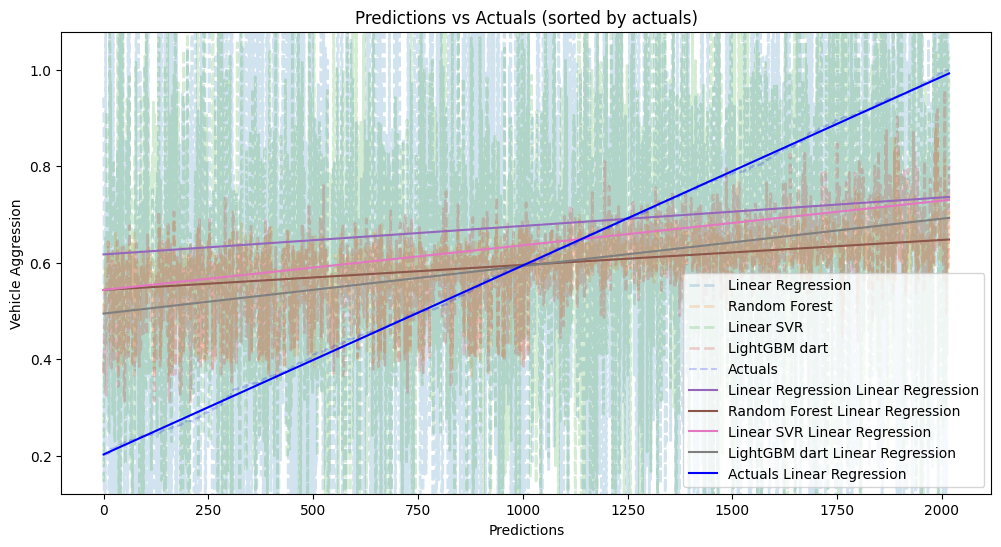

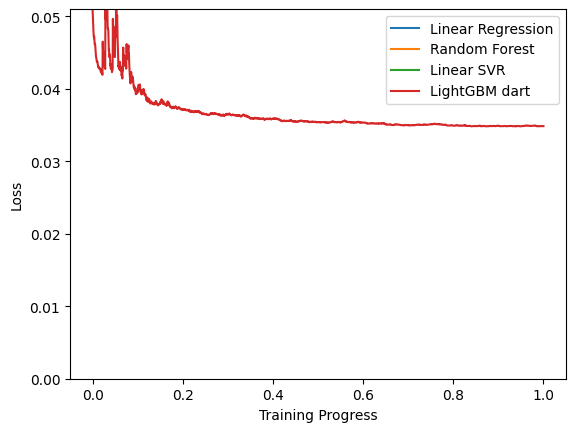

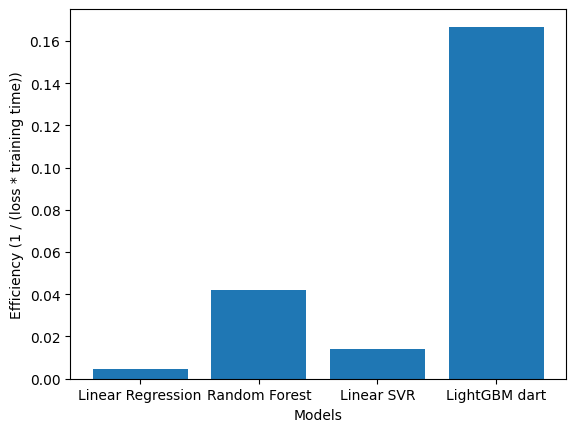

In [37]:
best_predictions = {}
for model, result in best_of_models.items():
    best_predictions[model] = result['predictions']
plot_evaluations(y_test, best_predictions)

best_losses_at_epoch = {}
for model, result in best_of_models.items():
    best_losses_at_epoch[model] = result['loss_at_epoch']
plot_trains(best_losses_at_epoch)

best_losses = {}
best_training_times = {}
for model, result in best_of_models.items():
    best_losses[model] = result['loss']
    best_training_times[model] = result['training_time']
plot_train_efficiencies(best_losses, best_training_times)

In [38]:
# Export best_of_models data to csv using pandas
import pandas as pd
import datetime as dt
# Create dataframe from best_of_models dictionary
# Row = model, Column = loss, training_time, number_of_epochs, Efficiency (1 / loss * training_time)
date = dt.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
best_models_df = pd.DataFrame()
model_losses_df = pd.DataFrame()
model_losses_progress_df = pd.DataFrame()
# Create table with rows: Model name, loss, epoch
for index, actual in enumerate(y_test):
    model_losses_df = model_losses_df.append({
        'Model': 'Actual',
        'Values': actual,
        'Prediction index': index,
        }, ignore_index=True)

for model in best_of_models:
    # Create table with rows: Model name, loss, number of epoch
    rows = []
    # iterate with index
    
    for index, prediction in enumerate(best_of_models[model]['predictions']):
        model_losses_df = model_losses_df.append({
            'Model': model,
            'Values': prediction,
            'Prediction index': index,
            }, ignore_index=True)
    # Resize loss_at_epoch to a 100 sized list with linear interpolation
    loss_at_epoch = best_of_models[model]['loss_at_epoch']
    if (len(loss_at_epoch) > 0):
        loss_at_epoch = [loss_at_epoch[int(np.floor(i * len(loss_at_epoch) / 100))] for i in range(100)]
        # Append table with model name as column and 100 rows as losses to model_losses_progress_df
        model_loss_progress = pd.DataFrame(columns=[model], data=loss_at_epoch)
        model_losses_progress_df = pd.concat([model_losses_progress_df, model_loss_progress], axis=1)
    
    best_models_df = best_models_df.append({
        'Model': model,
        'Loss': best_of_models[model]['loss'],
        'Training time (s)': best_of_models[model]['training_time'],
        'Number of Epochs': len(best_of_models[model]['loss_at_epoch']),
        'Efficiency': 1 / (best_of_models[model]['loss'] * best_of_models[model]['training_time']),
        }, ignore_index=True)

best_models_path = f'best_of_models_{date}.csv'
model_losses_path = f'model_losses_{date}.csv'
model_losses_progress_path = f'model_losses_progress_{date}.csv'
best_models_df.to_csv(best_models_path)
model_losses_df.to_csv(model_losses_path)
model_losses_progress_df.to_csv(model_losses_progress_path)

C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2558959265.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_losses_df = model_losses_df.append({
C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2558959265.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_losses_df = model_losses_df.append({
C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2558959265.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_losses_df = model_losses_df.append({
C:\Users\illya\AppData\Local\Temp\ipykernel_15816\2558959265.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_losses_df = model_losses_df.append({
C:\Users\illya\A

In [39]:
# dump best_of_models to pickle
import pickle
pickle.dump(best_of_models, open(f'best_of_models_{date}.pkl', 'wb'))

In [40]:
# read in pickle
# import pickle
# best_of_models = pickle.load(open('best_of_models_2023-05-29_09-50-10.pkl', 'rb'))
